In [1]:
import hyperspy.api as hs
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import cmasher as cmr
import os
import numba
import cv2
from IPython.display import Video
from scipy.optimize import curve_fit
from matplotlib.patches import Rectangle, Circle
from matplotlib.patches import Polygon
from matplotlib.path import Path
import re
import glob



In [2]:
nb_name = 'ROI2-RT-A2'

In [3]:
import hyperspy.api as hs
import re
import glob
import os

# 1. Define nb_name and base_path up to Hour_00
base_path = f"F:/1_ARM_BNL_2025-2/250610_FAPbI3_Beam_damage/ROI2-1/{nb_name}/Hour_00"

# 2. Define fixed subfolder: Minute_00/Second_05
target_path = os.path.join(base_path, "Minute_00", "Second_15")

# 3. Find the first .dm4 file in that folder
dm_files = sorted(glob.glob(os.path.join(target_path, "*.dm4")))
if not dm_files:
    raise FileNotFoundError(f"No .dm4 files found in {target_path}")

file_path = dm_files[0].replace("\\", "/")  # Normalize to forward slashes

# 4. Load the image
image_dm = hs.load(file_path)
image = image_dm.data


# 6. Print results
print("nb_name:", nb_name)
print("file_path:", file_path)


nb_name: ROI2-RT-A2
file_path: F:/1_ARM_BNL_2025-2/250610_FAPbI3_Beam_damage/ROI2-1/ROI2-RT-A2/Hour_00/Minute_00/Second_15/ROI2-RT-A2_Hour_00_Minute_00_Second_15_Frame_0000.dm4


In [4]:
# Constants
dose_rate = 30.93 # e/A²s
frames_per_second = 10  # Frames per second
dose_per_frame = dose_rate / frames_per_second  # Dose per frame

In [5]:
# Define scan parameters
scan_size = 700  # Size of the region to scan (500x500 pixels)
square_size = 100  # Size of the square ROI to scan
center_x, center_y = image.shape[1] // 2, image.shape[0] // 2  # Center of the image

# Define the scanning region boundaries
x_min = max(center_x - scan_size // 2, 0)
x_max = min(center_x + scan_size // 2, image.shape[1])
y_min = max(center_y - scan_size // 2, 0)
y_max = min(center_y + scan_size // 2, image.shape[0])

# Initialize variables to store maximum intensity and corresponding center
max_intensity_sum = -1
best_center = (0, 0)

# Scan through the region
for x in range(x_min, x_max - square_size + 1):
    for y in range(y_min, y_max - square_size + 1):
        # Extract the current ROI
        roi_data = image[y:y + square_size, x:x + square_size]
        
        # Calculate the intensity sum
        intensity_sum = np.sum(roi_data)
        
        # Update maximum intensity and best center
        if intensity_sum > max_intensity_sum:
            max_intensity_sum = intensity_sum
            best_center = (x + square_size // 2, y + square_size // 2)

# Save the best center to the `center` variable
center = best_center

image_height = image.shape[0]
image_width = image.shape[1]

# Print the updated center value
print(f"Updated Center: {center}, Max Intensity Sum: {max_intensity_sum:.2f}")


Updated Center: (1766, 1709), Max Intensity Sum: 167319.00


In [6]:
# ── Parameter Check & Interactive Mode ───────────────────────────────

# Set parameters directly here
predefined_params = {
    'scale': 1.05,
    'rotation_angle': 31,
    'center_x': 40,
    'center_y': -20,
    'blur_sigma': 10
}


crystal system 'cubic' is not interpreted for space group Spacegroup(221, setting=1). This may result in wrong setting!
This Atoms object contains occupancy information but it will be ignored.


✅ Using predefined parameters:
  scale: 1.05
  rotation_angle: 31
  center_x: 40
  center_y: -20
  blur_sigma: 10
💾 Parameters saved to parameters.json


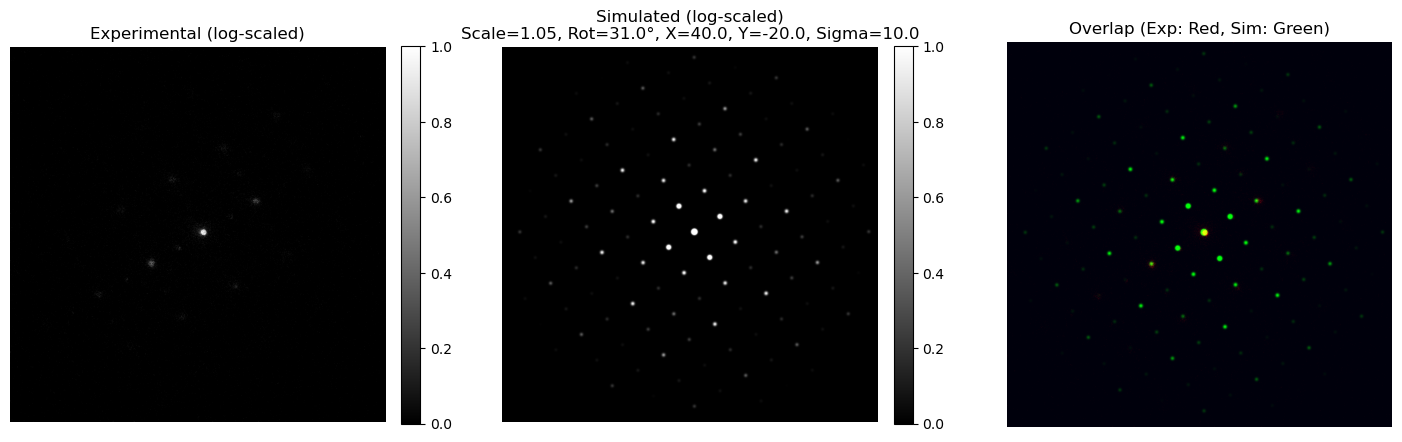

In [7]:
import py4DSTEM
import numpy as np
import hyperspy.api as hs
from scipy.ndimage import gaussian_filter, rotate, zoom, shift
import ipywidgets as widgets
from IPython.display import display
import json
import matplotlib.pyplot as plt
from ase.io import read

# ── Load Crystal Structure ───────────────────────────────────────────
crystal_ase = read('C:/structure/Cubic_Pm-3m.cif')
crystal = py4DSTEM.process.diffraction.Crystal.from_ase(crystal_ase)

# ── Load Experimental Pattern ────────────────────────────────────────
diffraction_image = image  # ← your experimental data
M = diffraction_image.shape[0]

# ── Simulate Diffraction Pattern ─────────────────────────────────────
crystal.calculate_dynamical_structure_factors(accelerating_voltage=200e3, method='Lobato')
ZA = np.array([0, 0, 1])
dp1 = crystal.generate_diffraction_pattern(zone_axis_lattice=ZA, sigma_excitation_error=0.02, tol_intensity=0.0)

thickness_compare = 400
pattern = crystal.generate_dynamical_diffraction_pattern(
    beams=dp1,
    thickness=thickness_compare,
    zone_axis_lattice=ZA
)

# ── Generate 2D Simulated Pattern ────────────────────────────────────
qx_min, qx_max = np.min(pattern.data['qx']), np.max(pattern.data['qx'])
qy_min, qy_max = np.min(pattern.data['qy']), np.max(pattern.data['qy'])
kx_max = max(abs(qx_min), abs(qx_max)) * 1.1
ky_max = max(abs(qy_min), abs(qy_max)) * 1.1
pixel_scale = kx_max * 2 / M
pattern_2d = np.zeros((M, M))

for idx in range(len(pattern.data['intensity'])):
    qx = pattern.data['qx'][idx]
    qy = pattern.data['qy'][idx]
    intensity = pattern.data['intensity'][idx]
    px = int((qx + kx_max) / pixel_scale)
    py = int((qy + ky_max) / pixel_scale)
    if 0 <= px < M and 0 <= py < M:
        pattern_2d[py, px] += intensity  # [y, x] order

# ── Plotting Function (single version) ───────────────────────────────
def plot_patterns(scale, rotation_angle, center_x, center_y, blur_sigma):
    brightness = 50.0  # fixed value

    blurred_pattern = gaussian_filter(pattern_2d, sigma=blur_sigma)
    scaled_pattern = zoom(blurred_pattern, scale, order=1)
    rotated_pattern = rotate(scaled_pattern, rotation_angle, reshape=False, order=1)

    if rotated_pattern.shape != (M, M):
        new_pattern = np.zeros((M, M))
        sy, sx = rotated_pattern.shape
        oy, ox = (M - sy) // 2, (M - sx) // 2
        if oy > 0 and ox > 0:
            new_pattern[oy:oy + sy, ox:ox + sx] = rotated_pattern
        else:
            new_pattern = rotated_pattern[-oy:-oy + M, -ox:-ox + M]
        rotated_pattern = new_pattern

    shifted_pattern = shift(rotated_pattern, [center_y, center_x], order=1, mode='constant', cval=0)

    exp_display = diffraction_image.astype(np.float32)
    sim_display = shifted_pattern.astype(np.float32)

    exp_norm = exp_display / np.max(exp_display) if np.max(exp_display) > 0 else exp_display
    sim_norm = sim_display / np.max(sim_display) if np.max(sim_display) > 0 else sim_display

    exp_plot = np.clip(np.log1p(exp_norm * brightness), 0, 1)
    sim_plot = np.clip(np.log1p(sim_norm * brightness), 0, 1)

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    im0 = axes[0].imshow(exp_plot, cmap='gray')
    axes[0].set_title('Experimental (log-scaled)')
    axes[0].axis('off')
    plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

    im1 = axes[1].imshow(sim_plot, cmap='gray')
    axes[1].set_title(f'Simulated (log-scaled)\nScale={scale:.2f}, Rot={rotation_angle:.1f}°, X={center_x:.1f}, Y={center_y:.1f}, Sigma={blur_sigma:.1f}')
    axes[1].axis('off')
    plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

    # exp_plot과 sim_plot이 2D 배열이어야 함
    assert exp_plot.ndim == 2 and sim_plot.ndim == 2, "exp_plot/sim_plot must be 2D!"

    overlap = np.zeros((M, M, 3))
    overlap[..., 0] = exp_plot ** 0.5
    overlap[..., 1] = sim_plot
    overlap[..., 2] = 0.05

    axes[2].imshow(np.clip(overlap, 0, 1))
    axes[2].set_title('Overlap (Exp: Red, Sim: Green)')
    axes[2].axis('off')
    
# ── Parameter Mode Handling ──────────────────────────────────────────
if all(v is not None for v in predefined_params.values()):
    print("✅ Using predefined parameters:")
    for key, value in predefined_params.items():
        print(f"  {key}: {value}")

    # Save to parameters.json
    with open('parameters.json', 'w') as f:
        json.dump(predefined_params, f, indent=4)
    print("💾 Parameters saved to parameters.json")

    # Plot with predefined
    plot_patterns(
        predefined_params['scale'],
        predefined_params['rotation_angle'],
        predefined_params['center_x'],
        predefined_params['center_y'],
        predefined_params['blur_sigma']
    )

else:
    print("⚠️ Predefined values missing. Launching interactive widgets...")

    def save_parameters(_):
        params = {
            'scale': scale_slider.value,
            'rotation_angle': rotation_slider.value,
            'center_x': center_x_slider.value,
            'center_y': center_y_slider.value,
            'blur_sigma': blur_sigma_slider.value
        }
        with open('parameters.json', 'w') as f:
            json.dump(params, f, indent=4)
        print("💾 Parameters saved to parameters.json")

    # Sliders
    scale_slider = widgets.FloatSlider(value=1.0, min=0.5, max=2.0, step=0.05, description='Scale:')
    rotation_slider = widgets.FloatSlider(value=0.0, min=-180.0, max=180.0, step=1.0, description='Rotation (°):')
    center_x_slider = widgets.FloatSlider(value=0.0, min=-100.0, max=100.0, step=1.0, description='Center X:')
    center_y_slider = widgets.FloatSlider(value=0.0, min=-100.0, max=100.0, step=1.0, description='Center Y:')
    blur_sigma_slider = widgets.FloatSlider(value=10.0, min=0.5, max=20.0, step=0.5, description='Blur Sigma:')

    save_button = widgets.Button(description="💾 Save Parameters")
    save_button.on_click(save_parameters)
    display(save_button)

    widgets.interact(
        plot_patterns,
        scale=scale_slider,
        rotation_angle=rotation_slider,
        center_x=center_x_slider,
        center_y=center_y_slider,
        blur_sigma=blur_sigma_slider
    )


Average PbI2 Intensity: 0.73
Average Perov Intensity: 0.12
Average Center Intensity: 2.77
Average Background Intensity: 0.08
Intensity Difference (Yellow - Background): 0.04


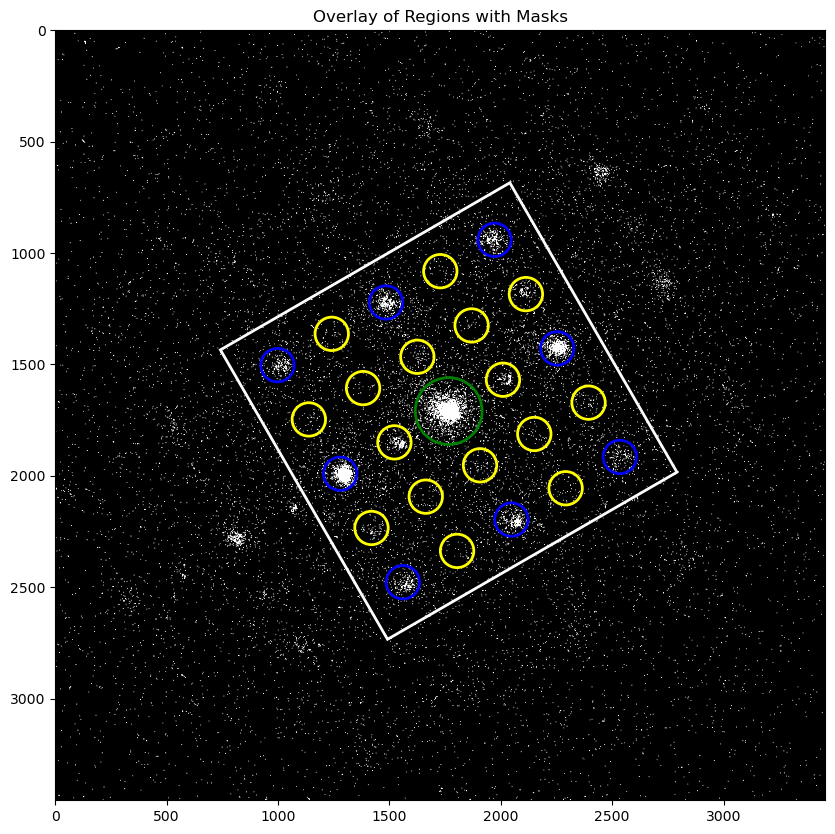

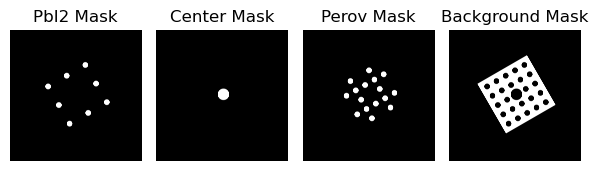

In [8]:
# Ensure image is single-channel (e.g., grayscale)
if image.ndim == 3:  # If image has multiple channels (e.g., RGB)
    image = image[:, :, 0]  # Select the first channel (or use np.mean(image, axis=2) for averaging)

# Define image dimensions and parameters
rect_side = 1500
rect_angle = -30 # degrees
circle_diameter = 150
center_circle_diameter = 300

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(image, cmap='gray',vmax=2)

# Helper function to rotate points around the center
def rotate_point(x, y, cx, cy, angle):
    rad = np.radians(angle)
    x_rot = np.cos(rad) * (x - cx) - np.sin(rad) * (y - cy) + cx
    y_rot = np.sin(rad) * (x - cx) + np.cos(rad) * (y - cy) + cy
    return x_rot, y_rot

# Generate positions for 25 circles in a square grid
spacing = 1125 / 4  # Spacing between adjacent circles
circle_positions = []
for i in range(-2, 3):  # Rows
    for j in range(-2, 3):  # Columns
        x = center[0] + j * spacing
        y = center[1] + i * spacing
        circle_positions.append((x, y))

# Rotate all circle positions
rotated_circle_positions = [rotate_point(x, y, center[0], center[1], rect_angle) for x, y in circle_positions]

# Function to draw a circle
def draw_circle(ax, center, diameter, color, **kwargs):
    circle = Circle((center[0], center[1]), diameter / 2, edgecolor=color, facecolor='none', linewidth=2, **kwargs)
    ax.add_patch(circle)

# Identify positions
PbI2_positions = [
    rotated_circle_positions[0], 
    rotated_circle_positions[4], 
    rotated_circle_positions[20], 
    rotated_circle_positions[24],
    rotated_circle_positions[2],  # Top-center
    rotated_circle_positions[10], # Left-center
    rotated_circle_positions[14], # Right-center
    rotated_circle_positions[22]  # Bottom-center
]

Perov_positions = [
    rotated_circle_positions[1],
    rotated_circle_positions[3], 
    rotated_circle_positions[5], 
    rotated_circle_positions[6], 
    rotated_circle_positions[7], 
    rotated_circle_positions[8], 
    rotated_circle_positions[9],
    rotated_circle_positions[11], 
    rotated_circle_positions[13], 
    rotated_circle_positions[15], 
    rotated_circle_positions[16], 
    rotated_circle_positions[19], 
    rotated_circle_positions[17], 
    rotated_circle_positions[18], 
    rotated_circle_positions[19], 
    rotated_circle_positions[21], 
    rotated_circle_positions[23], 
]

center_positions = [
    rotated_circle_positions[12]
]  

# Draw all rotated circles
for pos in rotated_circle_positions:
    if pos in PbI2_positions:
        draw_circle(ax, pos, circle_diameter, 'blue')
    elif pos in center_positions:
        draw_circle(ax, pos, center_circle_diameter, 'green')
    elif pos in Perov_positions:
        draw_circle(ax, pos, circle_diameter, 'yellow')

# Define the rectangle 
rect_origin = (
    center[0] - rect_side / 2 * np.cos(np.radians(rect_angle)) + rect_side / 2 * np.sin(np.radians(rect_angle)),
    center[1] - rect_side / 2 * np.sin(np.radians(rect_angle)) - rect_side / 2 * np.cos(np.radians(rect_angle))
)
rect = Rectangle(
    rect_origin,
    rect_side,
    rect_side,
    angle=rect_angle,
    linewidth=2,
    edgecolor='white',
    facecolor='none'
)
ax.add_patch(rect)

# Calculate intensity difference
# Create masks
mask_total = np.zeros_like(image, dtype=bool)
mask_PbI2 = np.zeros_like(image, dtype=bool)
mask_Center = np.zeros_like(image, dtype=bool)
mask_Perov= np.zeros_like(image, dtype=bool)

# Apply masks for yellow, blue, and green regions
for pos in rotated_circle_positions:
    rr, cc = np.ogrid[:image_height, :image_width]
    if pos in PbI2_positions:
        mask_PbI2 |= (rr - pos[1]) ** 2 + (cc - pos[0]) ** 2 <= (circle_diameter / 2) ** 2
    elif pos in center_positions:
        mask_Center |= (rr - pos[1]) ** 2 + (cc - pos[0]) ** 2 <= (center_circle_diameter / 2) ** 2
    elif pos in Perov_positions:
        mask_Perov |= (rr - pos[1]) ** 2 + (cc - pos[0]) ** 2 <= (circle_diameter / 2) ** 2

# Define the rectangle mask (inside the white rectangle)
rr, cc = np.ogrid[:image_height, :image_width]
rect_mask = (
    (cc >= rect_origin[0]) &
    (cc <= rect_origin[0] + rect_side * np.cos(np.radians(rect_angle))) &
    (rr >= rect_origin[1]) &
    (rr <= rect_origin[1] + rect_side * np.sin(np.radians(rect_angle)))
)

# Define rotated rectangle as a polygon
rect_corners = [
    rotate_point(center[0] - rect_side / 2, center[1] - rect_side / 2, center[0], center[1], rect_angle),
    rotate_point(center[0] + rect_side / 2, center[1] - rect_side / 2, center[0], center[1], rect_angle),
    rotate_point(center[0] + rect_side / 2, center[1] + rect_side / 2, center[0], center[1], rect_angle),
    rotate_point(center[0] - rect_side / 2, center[1] + rect_side / 2, center[0], center[1], rect_angle),
]

# Create a Path object for the rotated rectangle
rect_path = Path(rect_corners)

# Create mask for the rotated rectangle
xx, yy = np.meshgrid(np.arange(image_width), np.arange(image_height))
points = np.vstack((xx.ravel(), yy.ravel())).T
rect_mask_rotated = rect_path.contains_points(points).reshape(image.shape)

# Exclude blue, yellow, and green regions for background
mask_total |= mask_Perov | mask_PbI2 | mask_Center
mask_background = rect_mask_rotated & ~mask_total

# Calculate intensities
avg_PbI2_intensity = np.mean(image[mask_PbI2])
avg_Perov_intensity = np.mean(image[mask_Perov])
avg_Center_intensity = np.mean(image[mask_Center])
avg_background_intensity = np.mean(image[mask_background])

# Display intensities
print(f"Average PbI2 Intensity: {avg_PbI2_intensity:.2f}")
print(f"Average Perov Intensity: {avg_Perov_intensity:.2f}")
print(f"Average Center Intensity: {avg_Center_intensity:.2f}")
print(f"Average Background Intensity: {avg_background_intensity:.2f}")
print(f"Intensity Difference (Yellow - Background): {avg_Perov_intensity - avg_background_intensity:.2f}")

# Finalize plot
ax.set_xlim(0, image_width)
ax.set_ylim(image_height, 0)
ax.set_title("Overlay of Regions with Masks")
plt.show()

# Visualize all masks in a 1x4 array of subplots
fig, axes = plt.subplots(1, 4, figsize=(6, 2))

# Plot each mask
masks = [mask_PbI2, mask_Center, mask_Perov, mask_background]
titles = ["PbI2 Mask", "Center Mask", "Perov Mask", "Background Mask"]

for ax, mask, title in zip(axes, masks, titles):
    ax.imshow(mask, cmap='gray')
    ax.set_title(title)
    ax.axis('off')  # Hide axis for better visibility

# Adjust layout
plt.tight_layout()
plt.show()


In [9]:

image_list = []

# Find the total number of Minute directories
minute_dirs = [d for d in sorted(os.listdir(base_path)) if d.startswith("Minute_")]
end_of_min = len(minute_dirs)

# Iterate over the Minute directories (Minute_00, Minute_01, ...)
for min_idx, min_dir_name in enumerate(minute_dirs):
    min_dir = os.path.join(base_path, min_dir_name)
    
    # Find the total number of Second directories in the current Minute directory
    second_dirs = [d for d in sorted(os.listdir(min_dir)) if d.startswith("Second_")]
    end_of_sec = len(second_dirs)
    
    # Iterate over the Second directories (Second_00, Second_01, ...)
    for sec_idx, second_dir_name in enumerate(second_dirs):
        second_dir = os.path.join(min_dir, second_dir_name)
        
        # Get all the .dm4 files in the directory
        dm4_files = [f for f in sorted(os.listdir(second_dir)) if f.endswith(".dm4")]
        
        # Iterate through each .dm4 file
        for file_name in dm4_files:
            file_path = os.path.join(second_dir, file_name)
            
            # Load the .dm4 file using hyperspy
            image_dm = hs.load(file_path)  # Use hs.load() from hyperspy.api
            image_data = image_dm.data

            # Keep the original pixel values (no normalization)
            image_data_3d = cv2.cvtColor(image_data.astype(np.uint8), cv2.COLOR_GRAY2BGR)
            
            # Append the image data to the stack
            image_list.append(image_data_3d)

print(f"Processed {len(image_list)} images from {end_of_min} Minute directories and their Second subdirectories.")


Processed 223 images from 1 Minute directories and their Second subdirectories.


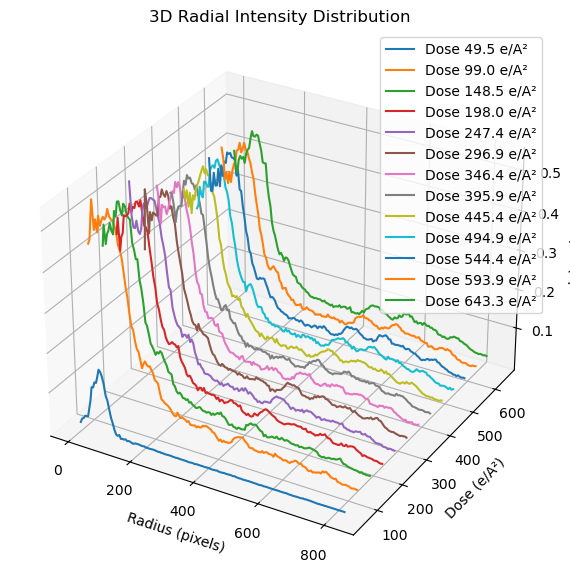

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# 원본 이미지 리스트에서 첫 5장을 제외
filtered_images = image_list[0:]

target_dose = 50  # 목표 총 선량
frames_per_set = int(target_dose / dose_per_frame)  # 한 세트당 프레임 수
num_sets = len(filtered_images) // frames_per_set  # 총 세트 개수

# 각 그룹별 summation (벡터 연산 활용하여 속도 개선)
summed_images = np.array([
    np.sum(filtered_images[i * frames_per_set:(i + 1) * frames_per_set], axis=0)
    for i in range(num_sets)
])

# 감마 보정 적용
gamma = 0.05  # 감마 값 조절 가능
summed_images = summed_images ** gamma

# 마지막 차원이 있는 경우 제거 (3D -> 2D 변환)
if summed_images.ndim == 4:
    summed_images = np.mean(summed_images, axis=-1)

# 전자 선량 계산
dose_values = np.array([dose_per_frame * frames_per_set * (i + 1) for i in range(num_sets)])

# 3D 플롯 설정
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Radial Profile 계산
for i, image in enumerate(summed_images):
    # Ensure image is 2D
    if image.ndim == 3:
        image = np.mean(image, axis=-1)

    # Define radial bins
    bin_size = 5  # Binning 크기 (픽셀 단위)
    y, x = np.indices(image.shape)
    distances = np.sqrt((x - center[1])**2 + (y - center[0])**2)
    max_distance = int(np.max(distances) / 3)
    bins = np.arange(0, max_distance + bin_size, bin_size)  # Radial bin 경계
    bin_indices = np.digitize(distances.ravel(), bins, right=True)  # Fix digitize issue

    # Calculate mean intensity for each bin
    radial_profile = np.zeros(len(bins) - 1)
    for j in range(1, len(bins)):
        mask = bin_indices == j
        radial_profile[j - 1] = np.nanmean(image.ravel()[mask]) if np.any(mask) else 0  # Handle empty bins

    # 3D Plot: 반경(bins), 강도(radial_profile), 전자 선량(dose_values)
    ax.plot(bins[:-1] + bin_size / 2, radial_profile, zs=dose_values[i], zdir='y', label=f"Dose {dose_values[i]:.1f} e/A²")

# 라벨 및 스타일 지정
ax.set_xlabel('Radius (pixels)')
ax.set_ylabel('Dose (e/A²)')
ax.set_zlabel('Intensity')
ax.set_title('3D Radial Intensity Distribution')

plt.legend()
plt.show()


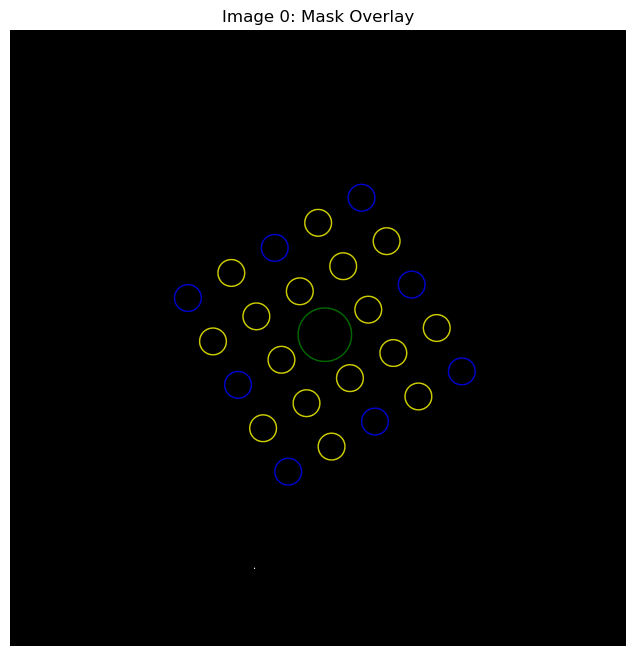

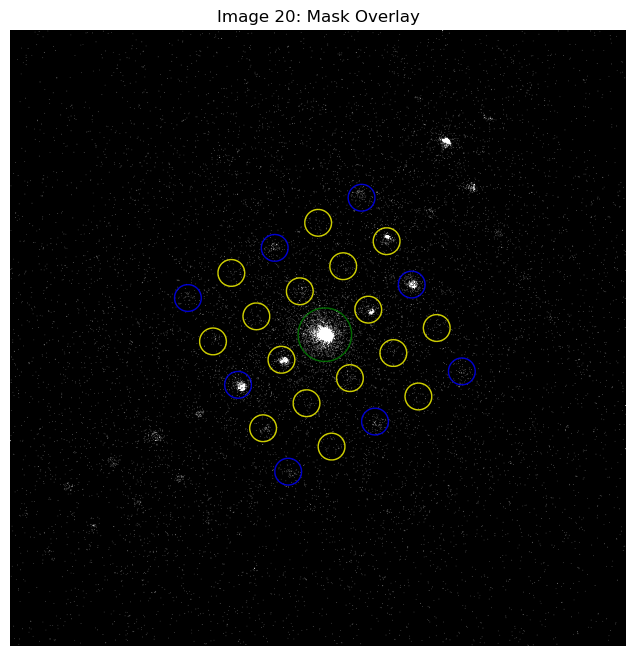

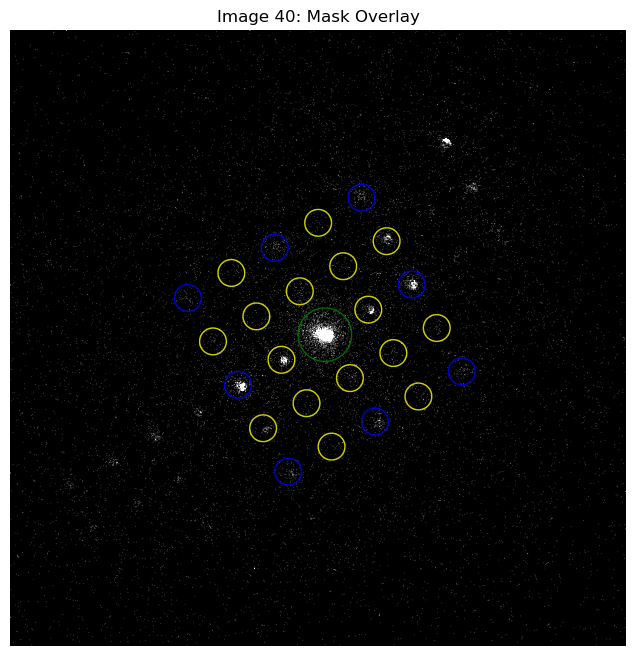

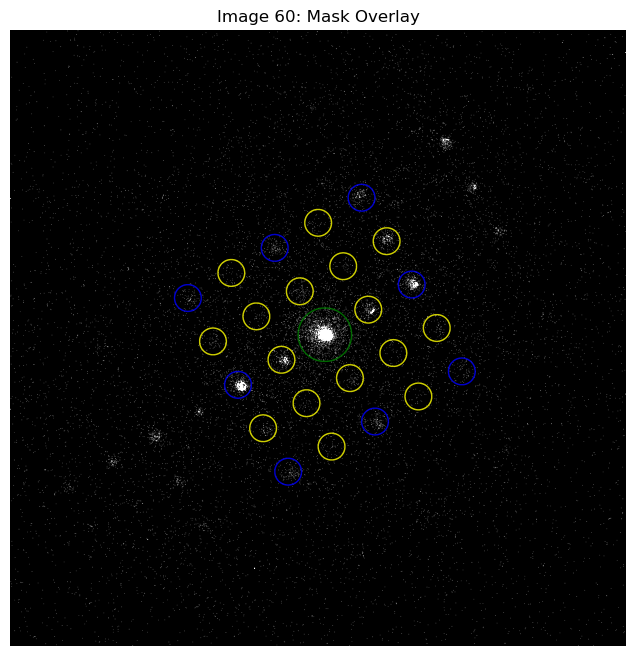

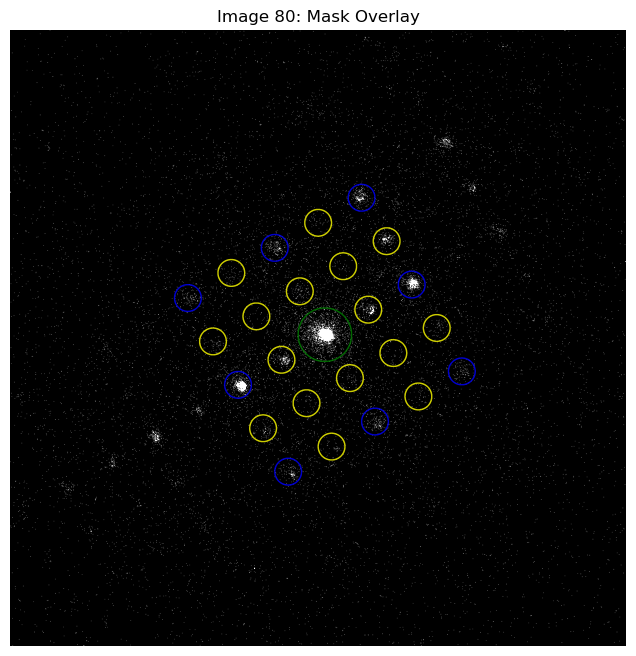

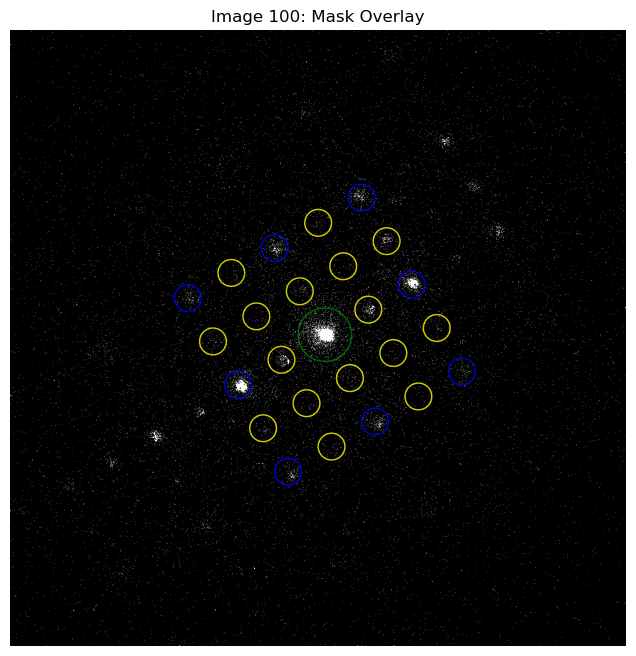

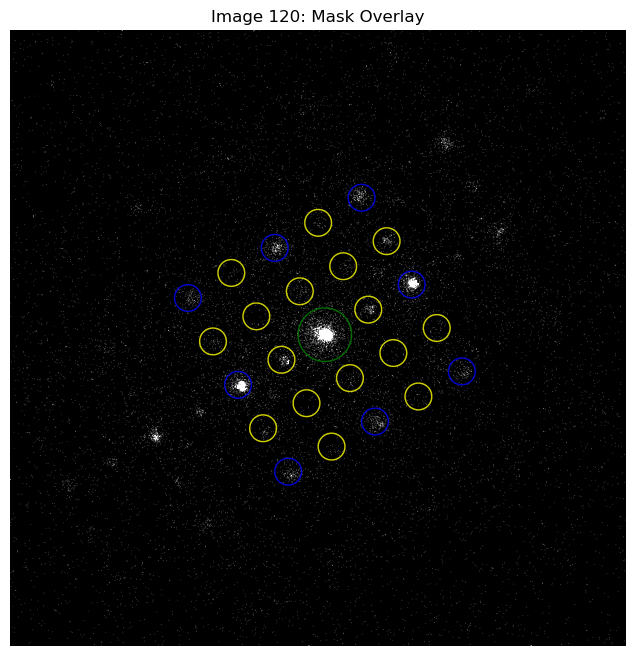

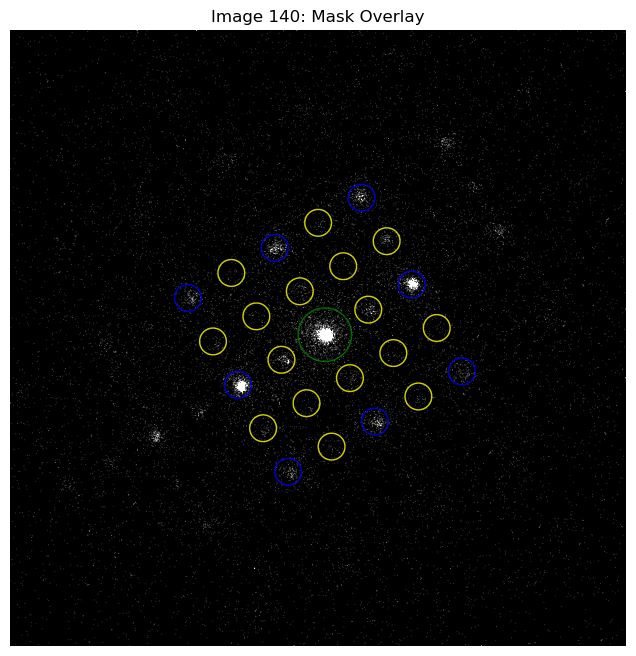

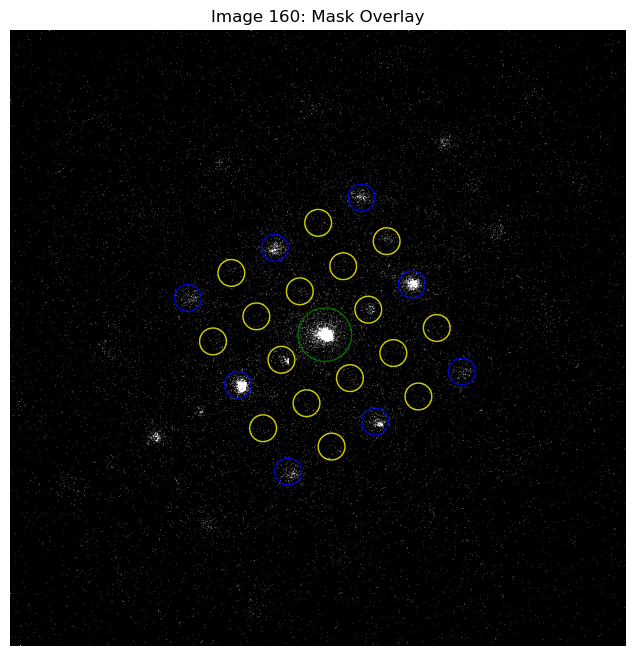

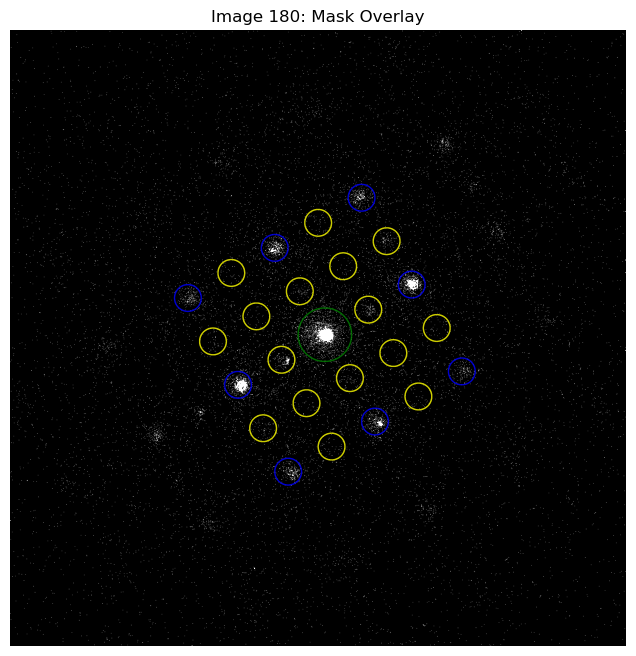

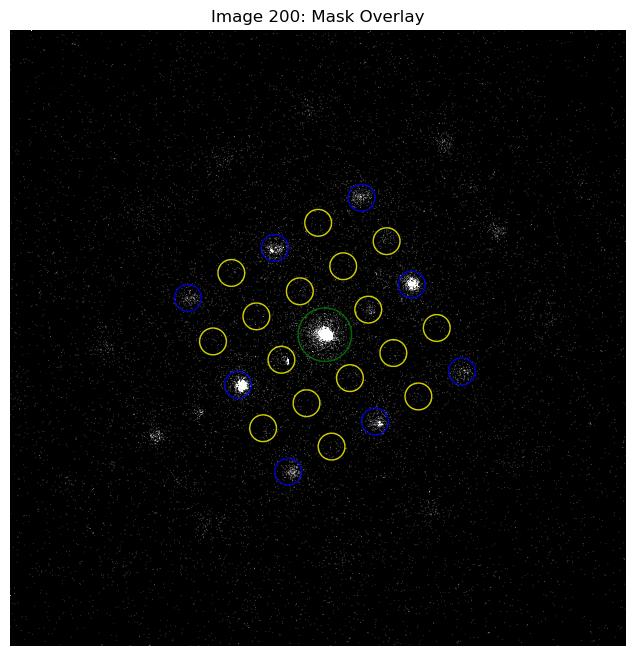

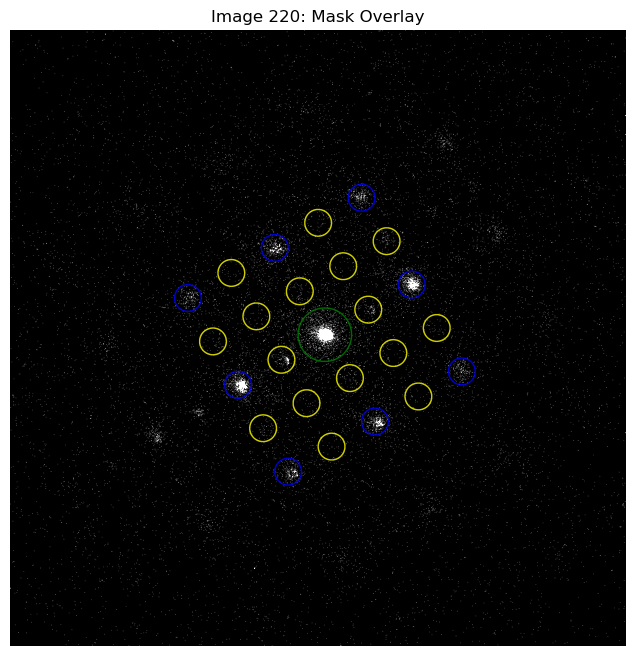

In [12]:
# Intensity differences 저장 리스트
PbI2_list = []
Perov_list = []
Center_list = []
background_list = []
difference_list = []
#radial_list = []

# 각 이미지에서 intensity difference 계산
for idx, image in enumerate(image_list):
    # 이미지를 그레이스케일로 변환 (NumPy 연산 활용)
    gray_image = np.dot(image[..., :3], [0.2989, 0.587, 0.114]).astype(np.float32)
    
    # Intensity 계산
    avg_PbI2_intensity = np.mean(gray_image[mask_PbI2])
    avg_Perov_intensity = np.mean(gray_image[mask_Perov])
    avg_Center_intensity = np.mean(gray_image[mask_Center])
    avg_background_intensity = np.mean(gray_image[mask_background])
    intensity_diff = avg_Perov_intensity - avg_background_intensity
    
    # y, x = np.indices(gray_image.shape)
    # distances = np.sqrt((x - center[1])**2 + (y - center[0])**2)
    # max_distance = int(np.max(distances)/2)
    # radial_profile = np.zeros(max_distance)
    # for r in range(1, max_distance):
    #     mask = (distances >= r - 0.5) & (distances < r + 0.5)
    #     radial_profile[r] = np.mean(image[mask])


    PbI2_list.append(avg_PbI2_intensity)
    Perov_list.append(avg_Perov_intensity)
    Center_list.append(avg_Center_intensity)
    background_list.append(avg_background_intensity)
    difference_list.append(intensity_diff)
    #radial_list.append(radial_profile)

    # 20장마다 마스크와 겹친 이미지 플롯
    if idx % 20 == 0:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.imshow(gray_image, cmap='gray', vmax=5)
        ax.contour(mask_PbI2, colors='blue', linewidths=1, alpha=0.8)
        ax.contour(mask_Perov, colors='yellow', linewidths=1, alpha=0.8)
        ax.contour(mask_Center, colors='green', linewidths=1, alpha=0.8)
        ax.set_title(f"Image {idx}: Mask Overlay")
        ax.axis('off')
        plt.show()



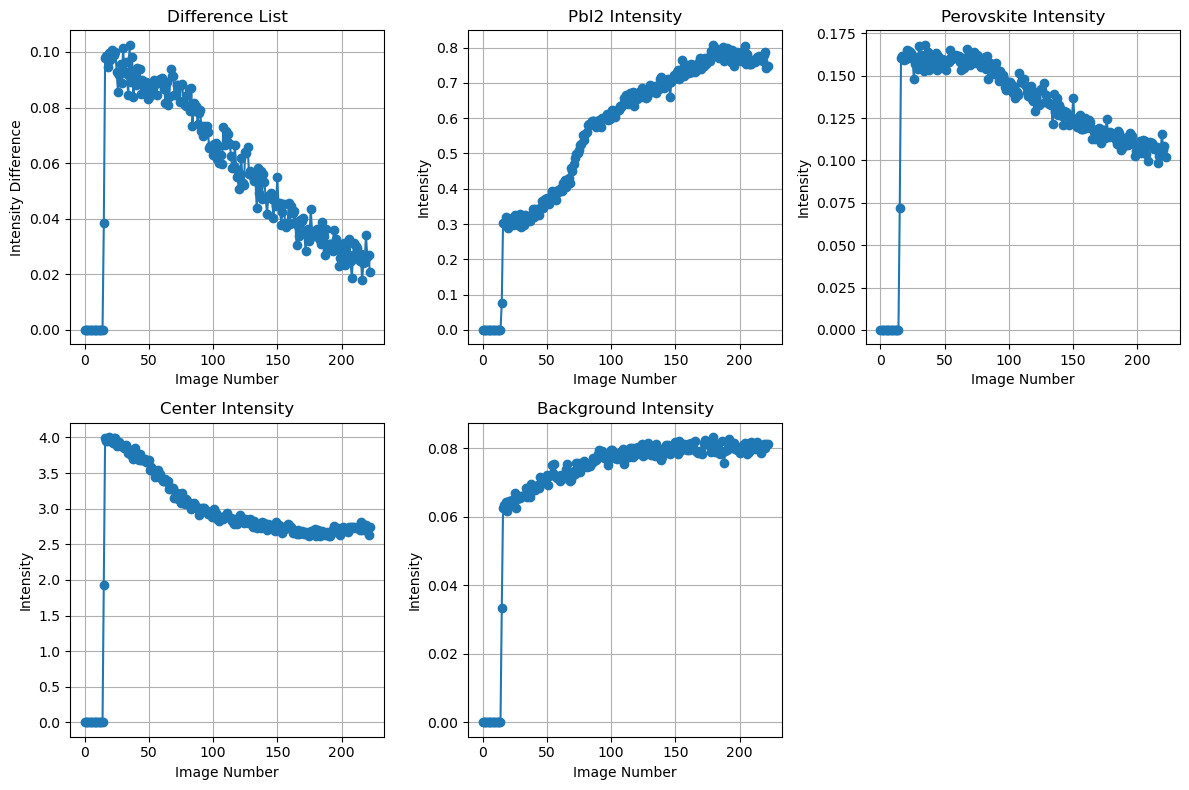

In [13]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Plotting the data in a 2x3 grid
axes[0, 0].plot(range(len(difference_list)), difference_list, marker='o')
axes[0, 0].set_title("Difference List")
axes[0, 0].set_xlabel("Image Number")
axes[0, 0].set_ylabel("Intensity Difference")
axes[0, 0].grid()

axes[0, 1].plot(range(len(PbI2_list)), PbI2_list, marker='o')
axes[0, 1].set_title("PbI2 Intensity")
axes[0, 1].set_xlabel("Image Number")
axes[0, 1].set_ylabel("Intensity")
axes[0, 1].grid()

axes[0, 2].plot(range(len(Perov_list)), Perov_list, marker='o')
axes[0, 2].set_title("Perovskite Intensity")
axes[0, 2].set_xlabel("Image Number")
axes[0, 2].set_ylabel("Intensity")
axes[0, 2].grid()

axes[1, 0].plot(range(len(Center_list)), Center_list, marker='o')
axes[1, 0].set_title("Center Intensity")
axes[1, 0].set_xlabel("Image Number")
axes[1, 0].set_ylabel("Intensity")
axes[1, 0].grid()

axes[1, 1].plot(range(len(background_list)), background_list, marker='o')
axes[1, 1].set_title("Background Intensity")
axes[1, 1].set_xlabel("Image Number")
axes[1, 1].set_ylabel("Intensity")
axes[1, 1].grid()

# Hide the last subplot (empty one)
axes[1, 2].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()


In [14]:
# 1. 최대값 찾기
# Ensure y_data is defined
y_data = np.array(difference_list)  # Assuming y_data corresponds to difference_list
y_max = np.max(y_data)

# 2. y_max의 몇 % 이상에서 시작할 것인지 정함 (예: 90%)
threshold_ratio = 0.9
threshold_value = y_max * threshold_ratio

# 3. threshold 이상 중 첫 번째 index (즉, 감소 시작점 이전의 최대값 근처)
start_index = np.argmax(y_data >= threshold_value)

# 4. 이후 처리는 동일
cumulative_dose = np.arange(len(y_data)) * dose_per_frame

if start_index < len(cumulative_dose):
    cumulative_dose = cumulative_dose[start_index:] - cumulative_dose[start_index]
    difference_list_adjusted = y_data[start_index:]
    PbI2_list_adjusted = np.array(PbI2_list[start_index:])
    Perov_list_adjusted = np.array(Perov_list[start_index:])
    Center_list_adjusted = np.array(Center_list[start_index:])
    background_list_adjusted = np.array(background_list[start_index:])
else:
    # fallback: 아무 변화 없음
    difference_list_adjusted = y_data
    PbI2_list_adjusted = np.array(PbI2_list)
    Perov_list_adjusted = np.array(Perov_list)
    Center_list_adjusted = np.array(Center_list)
    background_list_adjusted = np.array(background_list)

# 길이 정렬
min_length = min(len(cumulative_dose), 
                 len(difference_list_adjusted), 
                 len(PbI2_list_adjusted), 
                 len(Perov_list_adjusted), 
                 len(Center_list_adjusted), 
                 len(background_list_adjusted))

cumulative_dose = cumulative_dose[:min_length]
difference_list_adjusted = difference_list_adjusted[:min_length]
PbI2_list_adjusted = PbI2_list_adjusted[:min_length]
Perov_list_adjusted = Perov_list_adjusted[:min_length]
Center_list_adjusted = Center_list_adjusted[:min_length]
background_list_adjusted = background_list_adjusted[:min_length]



# # Ensure y_data is defined
# y_data = np.array(difference_list)  # Assuming y_data corresponds to difference_list

# # Adjust dose and profiles to start from the first significant dose threshold
# start_index = np.argmax(np.array(difference_list) > 0.2) + 1  # Example threshold
# cumulative_dose = np.arange(len(y_data)) * dose_per_frame

# if start_index < len(cumulative_dose):
#     cumulative_dose = cumulative_dose[start_index:] - cumulative_dose[start_index]
#     difference_list_adjusted = np.array(difference_list[start_index:])
#     PbI2_list_adjusted = np.array(PbI2_list[start_index:])
#     Perov_list_adjusted = np.array(Perov_list[start_index:])
#     Center_list_adjusted = np.array(Center_list[start_index:])
#     background_list_adjusted = np.array(background_list[start_index:])
# else:
#     cumulative_dose = cumulative_dose
#     difference_list_adjusted = np.array(difference_list)
#     PbI2_list_adjusted = np.array(PbI2_list)
#     Perov_list_adjusted = np.array(Perov_list)
#     Center_list_adjusted = np.array(Center_list)
#     background_list_adjusted = np.array(background_list)

# # Ensure all lists match in length
# min_length = min(len(cumulative_dose), 
#                  len(difference_list_adjusted), 
#                  len(PbI2_list_adjusted), 
#                  len(Perov_list_adjusted), 
#                  len(Center_list_adjusted), 
#                  len(background_list_adjusted))

# # Truncate all lists to the minimum length
# cumulative_dose = cumulative_dose[:min_length]
# difference_list_adjusted = difference_list_adjusted[:min_length]
# PbI2_list_adjusted = PbI2_list_adjusted[:min_length]
# Perov_list_adjusted = Perov_list_adjusted[:min_length]
# Center_list_adjusted = Center_list_adjusted[:min_length]
# background_list_adjusted = background_list_adjusted[:min_length]


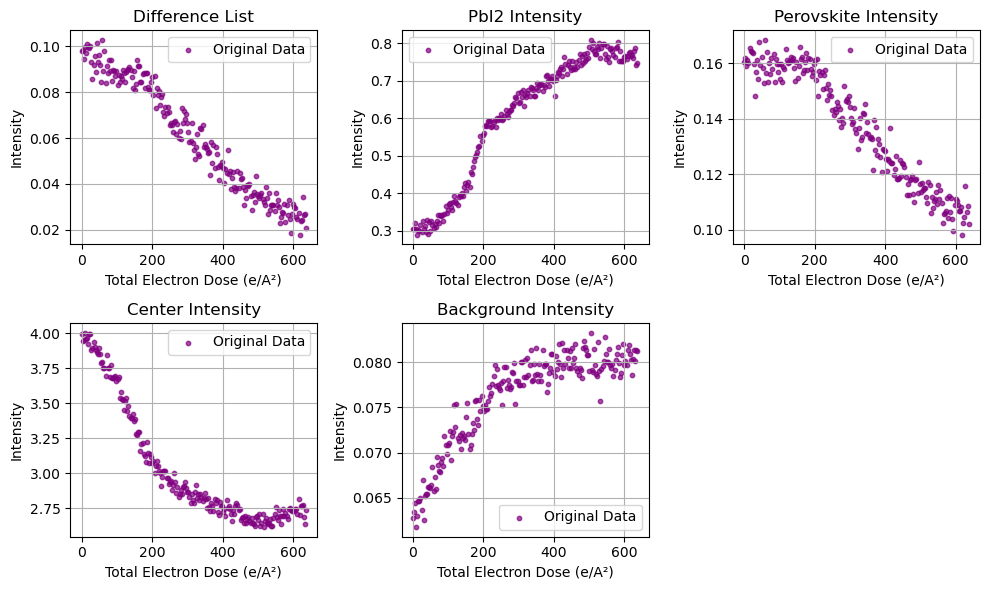

In [15]:
# List of datasets and titles
data_lists = [
    (difference_list_adjusted, "Difference List"),
    (PbI2_list_adjusted, "PbI2 Intensity"),
    (Perov_list_adjusted, "Perovskite Intensity"),
    (Center_list_adjusted, "Center Intensity"),
    (background_list_adjusted, "Background Intensity"),
]

# Plotting in a 2x3 grid
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
axes = axes.ravel()  # Flatten the axes array for easier indexing

for i, (data, title) in enumerate(data_lists):
    axes[i].scatter(cumulative_dose, data, label="Original Data", color="purple", alpha=0.7, s=10)
    axes[i].set_title(title)
    axes[i].set_xlabel("Total Electron Dose (e/A²)")
    axes[i].set_ylabel("Intensity")
    axes[i].grid()
    axes[i].legend()

# Hide the empty subplot if any
if len(data_lists) < len(axes):
    axes[-1].axis("off")

plt.tight_layout()
plt.show()


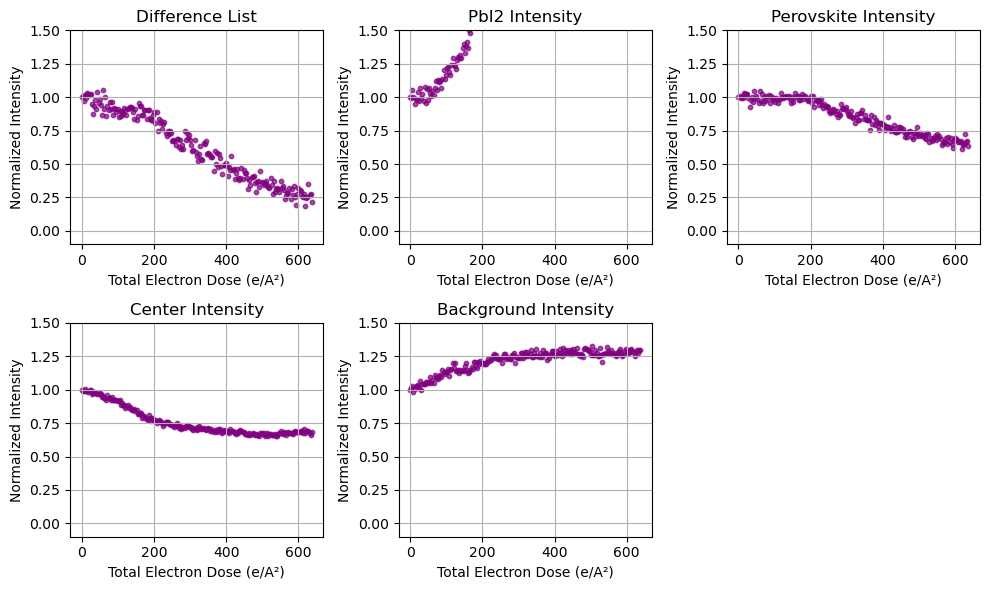

In [16]:
# List of datasets and titles
data_lists = [
    (difference_list_adjusted, "Difference List"),
    (PbI2_list_adjusted, "PbI2 Intensity"),
    (Perov_list_adjusted, "Perovskite Intensity"),
    (Center_list_adjusted, "Center Intensity"),
    (background_list_adjusted, "Background Intensity"),
]

# Function to normalize data
def normalize(data):
    first_val = data[0]  # 첫 번째 값
    return [val / first_val for val in data]

# Plotting in a 2x3 grid
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
axes = axes.ravel()  # Flatten the axes array for easier indexing

for i, (data, title) in enumerate(data_lists):
    normalized_data = normalize(data)  # Normalize the data
    axes[i].scatter(cumulative_dose, normalized_data, label="Normalized Data", color="purple", alpha=0.7, s=10)
    axes[i].set_title(title)
    axes[i].set_xlabel("Total Electron Dose (e/A²)")
    axes[i].set_ylabel("Normalized Intensity")
    axes[i].set_ylim(-0.1, 1.5)  # Set y-axis limits
    axes[i].grid()

# Hide the empty subplot if any
if len(data_lists) < len(axes):
    axes[-1].axis("off")

plt.tight_layout()
plt.show()


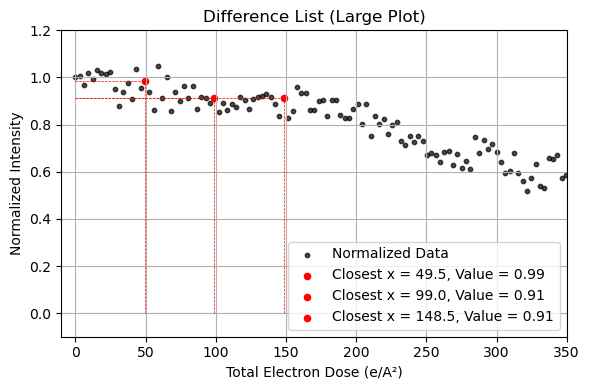

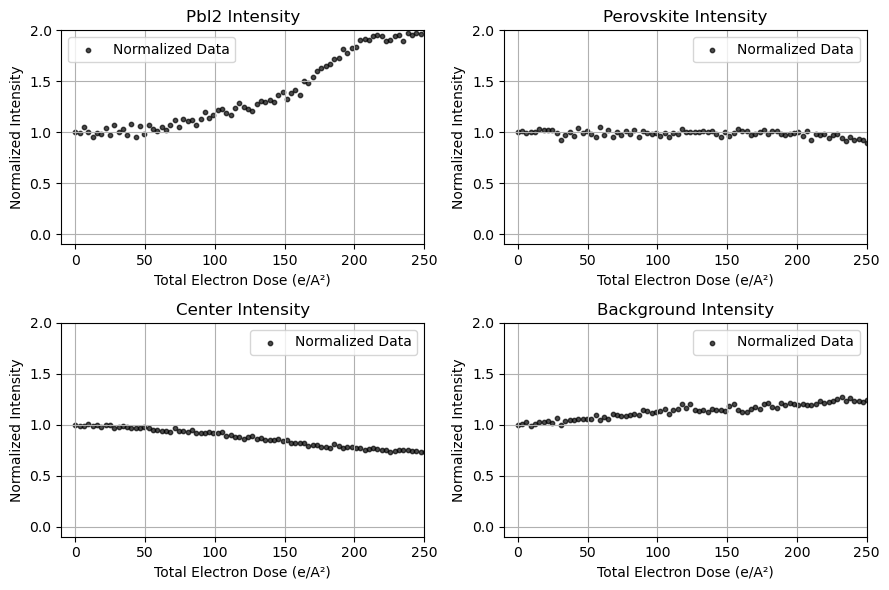

In [17]:
from matplotlib.lines import Line2D

# List of datasets and titles
data_lists = [
    (difference_list_adjusted, "Difference List"),
    (PbI2_list_adjusted, "PbI2 Intensity"),
    (Perov_list_adjusted, "Perovskite Intensity"),
    (Center_list_adjusted, "Center Intensity"),
    (background_list_adjusted, "Background Intensity"),
]

# Function to normalize data
def normalize(data):
    first_val = data[0]  # 첫 번째 값
    return [val / first_val for val in data]

# Function to find the closest index for a given value
def find_closest_index(array, value):
    return np.argmin(np.abs(array - value))

# Plotting for Difference List (large plot)
fig_diff, ax_diff = plt.subplots(figsize=(6, 4))
normalized_diff = normalize(difference_list_adjusted)  # Normalize Difference List
ax_diff.scatter(cumulative_dose, normalized_diff, label="Normalized Data", color="black", alpha=0.7, s=10)
ax_diff.set_title("Difference List (Large Plot)")
ax_diff.set_xlabel("Total Electron Dose (e/A²)")
ax_diff.set_ylabel("Normalized Intensity")
ax_diff.set_ylim(-0.1, 1.2)  # Set y-axis limits
ax_diff.set_xlim(-10,350)
ax_diff.grid()

# Highlight specific points for Difference List plot
for dose in [50, 100, 150]:
    idx = find_closest_index(cumulative_dose, dose)  # Find the index of the closest dose
    x, y = cumulative_dose[idx], normalized_diff[idx]  # Get (x, y) coordinates
    ax_diff.scatter(x, y, color="red", s=20, label=f"Closest x = {x:.1f}, Value = {y:.2f}")  # Highlight point
    
    # Add lines to x and y axes only
    line_x = Line2D([x, x], [0, y], color="red", linestyle="--", linewidth=0.5)  # Vertical line to x-axis
    line_y = Line2D([0, x], [y, y], color="red", linestyle="--", linewidth=0.5)  # Horizontal line to y-axis
    ax_diff.add_line(line_x)
    ax_diff.add_line(line_y)

ax_diff.legend()  # Add legend to Difference List plot
plt.tight_layout()
plt.show()

# Plotting for other datasets (2x2 grid)
fig_others, axes_others = plt.subplots(2, 2, figsize=(9, 6))
axes_others = axes_others.ravel()  # Flatten the axes array for easier indexing

for i, (data, title) in enumerate(data_lists[1:]):  # Skip the first dataset (Difference List)
    normalized_data = normalize(data)  # Normalize the data
    axes_others[i].scatter(cumulative_dose, normalized_data, label="Normalized Data", color="black", alpha=0.7, s=10)
    axes_others[i].set_title(title)
    axes_others[i].set_xlabel("Total Electron Dose (e/A²)")
    axes_others[i].set_ylabel("Normalized Intensity")
    axes_others[i].set_ylim(-0.1, 2.0)  # Set x-axis limits 
    axes_others[i].set_xlim(-10, 250)  # Set x-axis limits
    axes_others[i].grid()
    axes_others[i].legend()

# Hide the empty subplot if any
if len(data_lists[1:]) < len(axes_others):
    axes_others[-1].axis("off")

plt.tight_layout()
plt.show()

In [18]:
# --- 1단계: start_index 이후부터 이미지 사용 ---
filtered_images = image_list[start_index:]

# --- 2단계: 프레임 수 계산 (기존 정의된 dose_per_frame 사용) ---
frames_per_set = int(50 / dose_per_frame)  # 50 e/Å²마다 합칠 프레임 수
num_sets = len(filtered_images) // frames_per_set

# --- 3단계: 이미지 합치기 ---
summed_images = np.array([
    np.sum(filtered_images[i * frames_per_set:(i + 1) * frames_per_set], axis=0)
    for i in range(num_sets)
])

# --- 4단계: RGB인 경우 grayscale로 변환 (선택사항) ---
if summed_images.ndim == 4 and summed_images.shape[-1] == 3:
    summed_images = np.mean(summed_images, axis=-1)

# --- 5단계: 감마 보정 ---
gamma = 0.01
summed_images = summed_images ** gamma

# # --- 6단계: 시각화 ---
# dose_values = np.array([50 * (i + 1) for i in range(num_sets)])

# for i, img in enumerate(summed_images):
#     plt.figure(figsize=(5, 5))
#     plt.imshow(img, cmap='gray')
#     plt.axis("off")
#     plt.text(10, 20, f"{dose_values[i]:.1f} e/Å²", color='red', fontsize=12, weight='bold',
#              bbox=dict(facecolor='white', alpha=0.7))
#     plt.show()


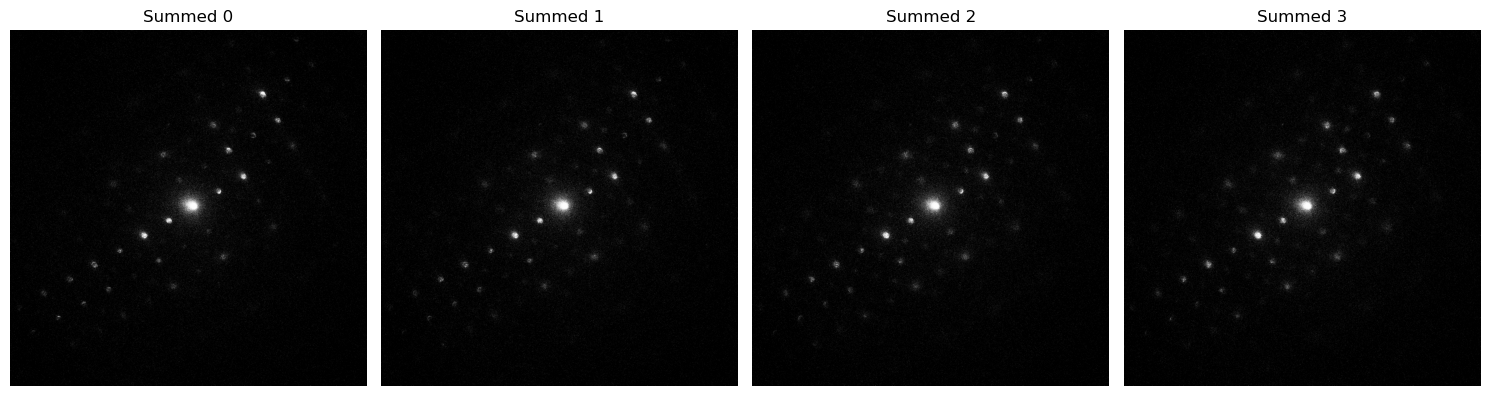

In [ ]:
# j = 4
# fig, ax = plt.subplots(1, j, figsize=(15, 4))

# for i in range(j):
#     ax[i].imshow(summed_images[i], cmap='gray')
#     ax[i].set_title(f'Summed {i}')
#     ax[i].axis('off')

# plt.tight_layout()
# plt.show()


100%|██████████| 100/100 [04:27<00:00,  2.67s/it]


✅ Image saved to: c:\Users\bgil\OneDrive - Brookhaven National Laboratory\Desktop\Beam damage\250610_Beam_Damage\2-1\DP-mistilts\ROI2-RT-A2.png


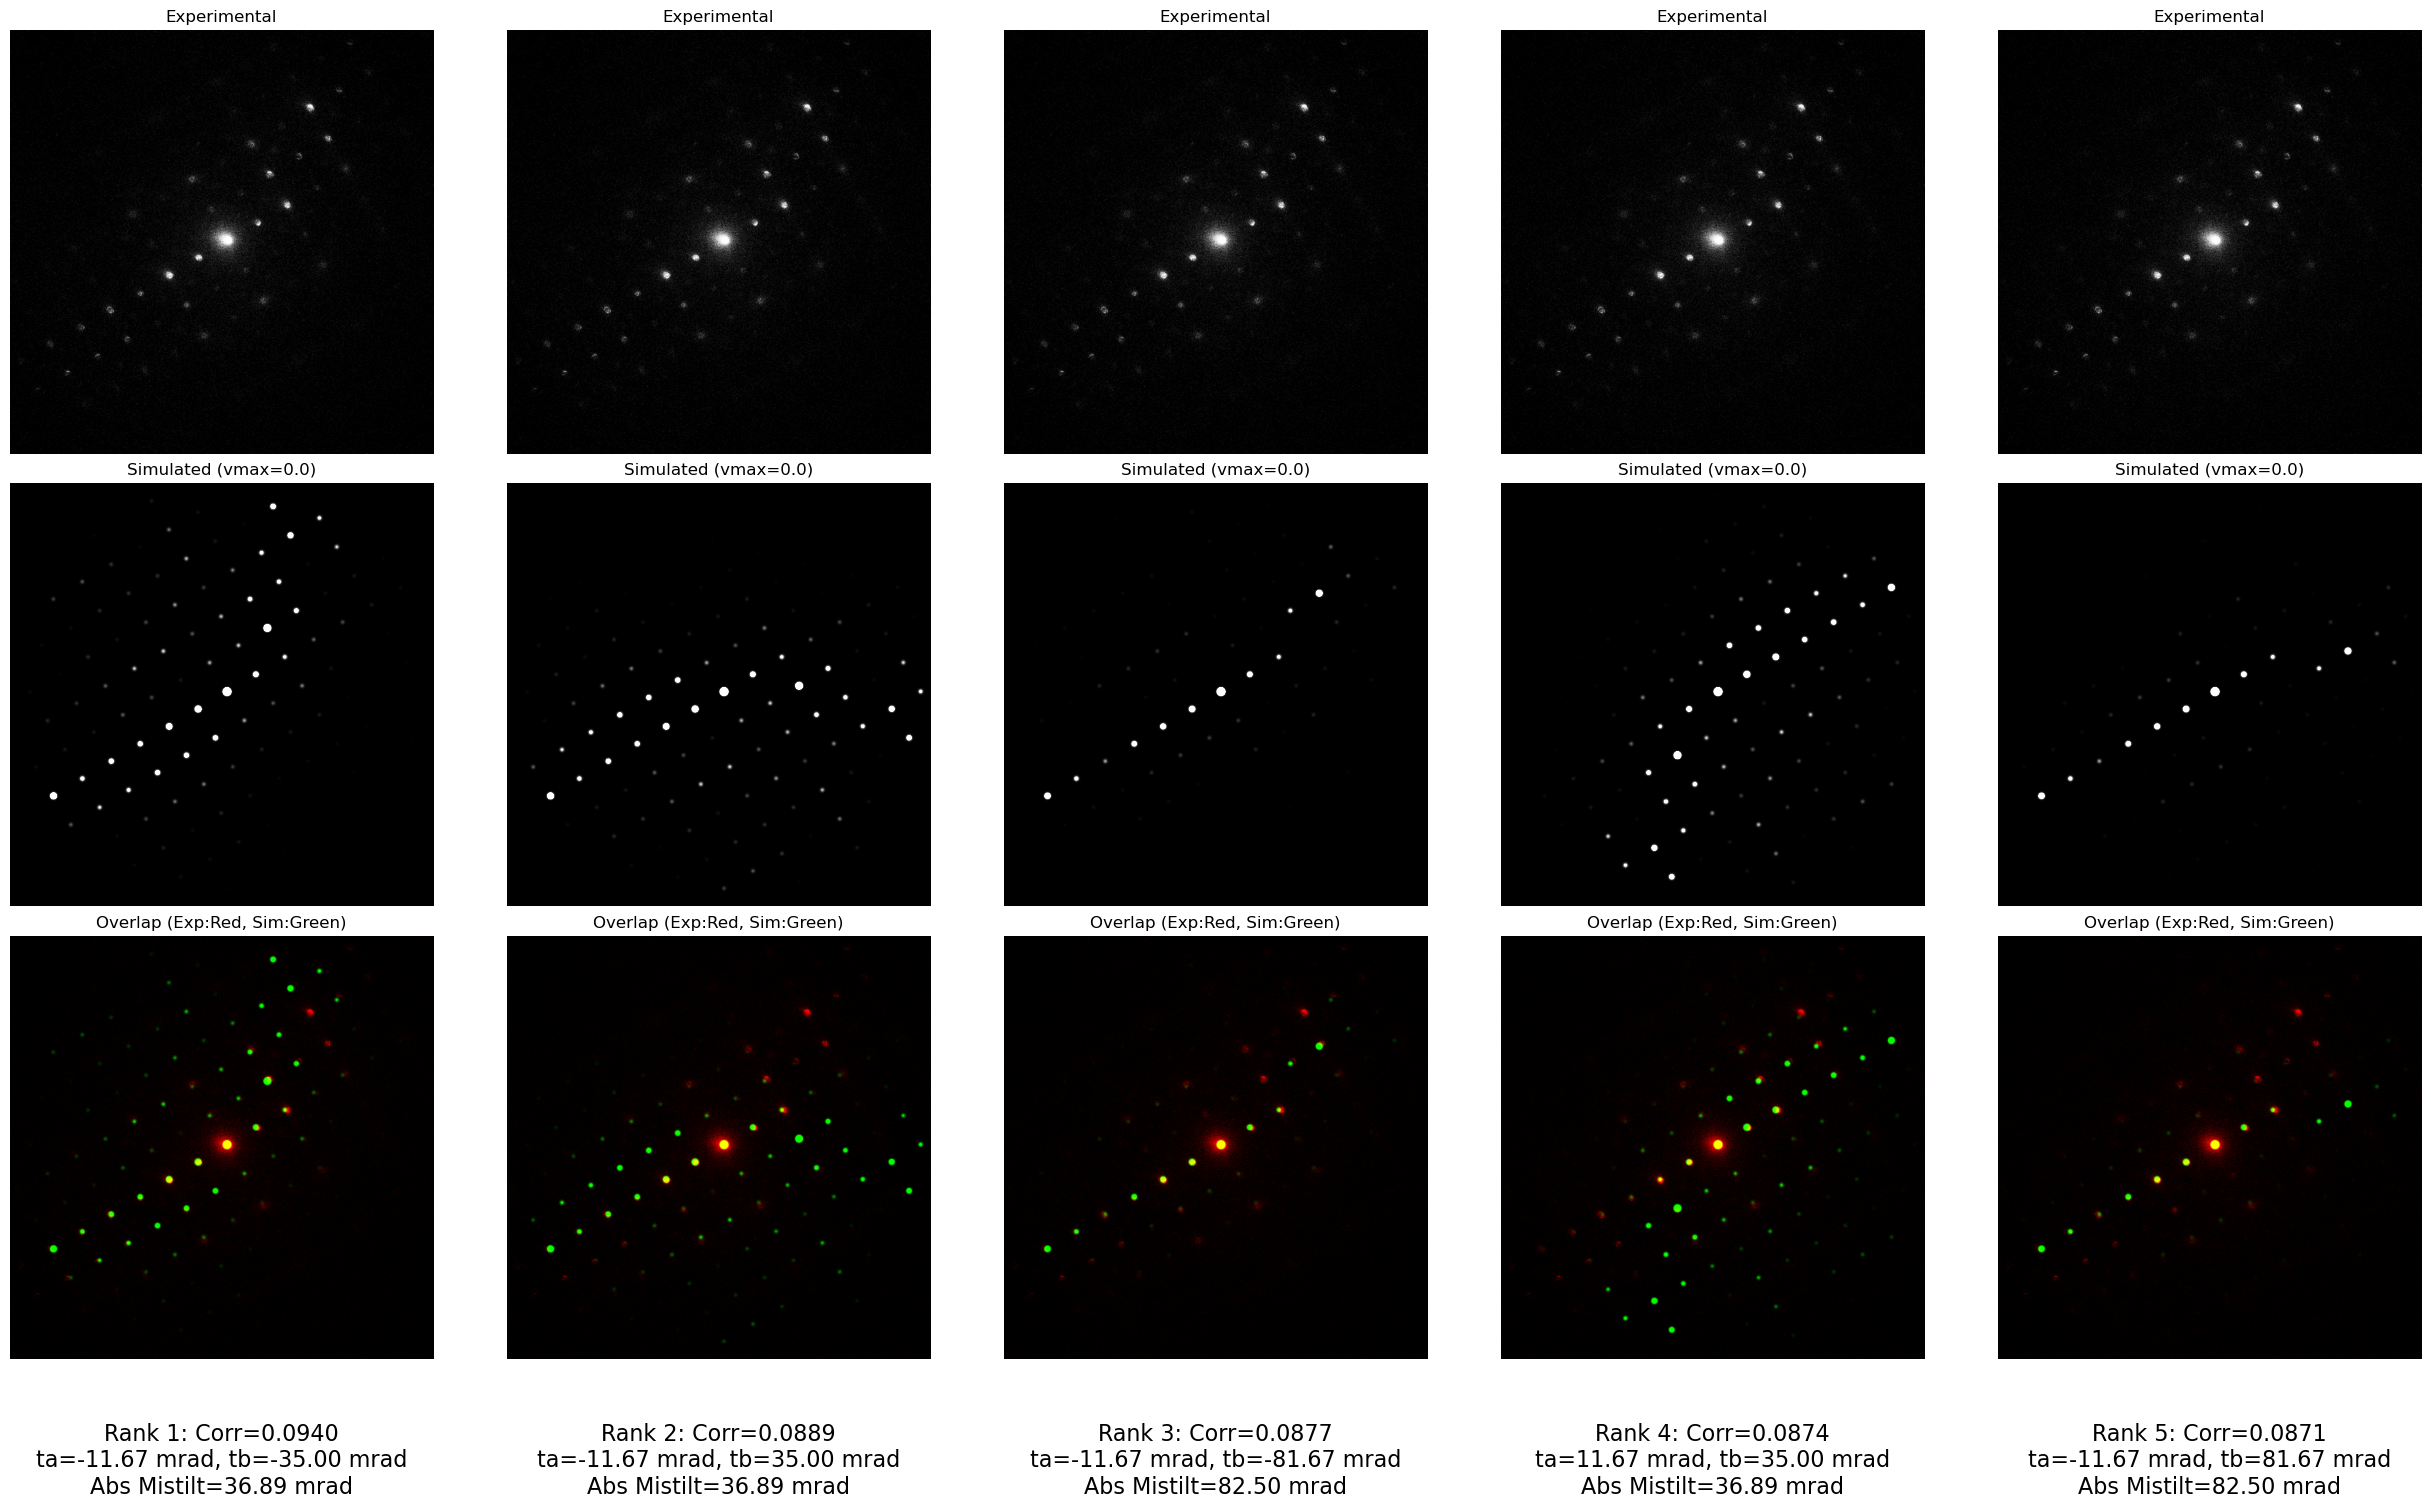

In [25]:
import os
import json
import numpy as np
import hyperspy.api as hs
import py4DSTEM
from scipy.spatial.transform import Rotation as R
from scipy.ndimage import gaussian_filter, rotate, shift, zoom
import matplotlib.pyplot as plt
from tqdm import tqdm

# ─── 저장된 파라미터 로드 ─────────────────────────────────
try:
    with open('parameters.json', 'r') as f:
        params = json.load(f)
    scale          = params.get('scale', 1.0)
    rotation_angle = params.get('rotation_angle', 0.0)
    center_x       = params.get('center_x', 0.0)
    center_y       = params.get('center_y', 0.0)
    intensity_scale= params.get('intensity_scale',
                        params.get('sim_intensity', 5.0))
    blur_sigma     = params.get('blur_sigma', 5.0)
except FileNotFoundError:
    print("parameters.json not found. Using default values.")
    scale          = 1.0
    rotation_angle = 0.0
    center_x       = 0.0
    center_y       = 0.0
    intensity_scale= 5.0
    blur_sigma     = 5.0

# ─── 실험 회절 이미지 로드 ─────────────────────────────────
diffraction_image = summed_images[0]
M = diffraction_image.shape[0]

# ─── 틸트 설정 ──────────────────────────────────────────────
rot_axis_a = np.array([0., 1., 0.]) 
rot_axis_a /= np.linalg.norm(rot_axis_a)
rot_axis_b = np.array([-1., 0., 0.])
rot_axis_b /= np.linalg.norm(rot_axis_b)
rot_a = 105  # mrad
rot_b = 105  # mrad
N_tilt = 10
thickness_compare = 400

tilt_a, tilt_b = np.meshgrid(
    np.linspace(-rot_a, rot_a, N_tilt),
    np.linspace(-rot_b, rot_b, N_tilt)
)

simulated_patterns = np.zeros((N_tilt, N_tilt, M, M))

# ─── 메인 루프 ───────────────────────────────────────────────
for idx in tqdm(range(N_tilt * N_tilt)):
    i, j = divmod(idx, N_tilt)
    ta = float(tilt_a.flat[idx])
    tb = float(tilt_b.flat[idx])

    # 회전 적용
    Ra = R.from_rotvec((ta / 1000.0) * rot_axis_a)
    Rb = R.from_rotvec((tb / 1000.0) * rot_axis_b)
    tilted_ZA = (Ra * Rb).apply([0, 0, 1])

    # 시뮬레이션 패턴 생성
    pattern = crystal.generate_dynamical_diffraction_pattern(
        beams=dp1,
        thickness=thickness_compare,
        zone_axis_lattice=tilted_ZA
    )

    # 2D 매핑
    qx, qy, I = pattern.data['qx'], pattern.data['qy'], pattern.data['intensity']
    kx_max = max(abs(qx.min()), qx.max()) * 1.1
    ky_max = max(abs(qy.min()), qy.max()) * 1.1
    pixel_scale = 2 * kx_max / M

    pat2d = np.zeros((M, M))
    for qxi, qyi, Ii in zip(qx, qy, I):
        px = int((qxi + kx_max) / pixel_scale)
        py = int((qyi + ky_max) / pixel_scale)
        if 0 <= px < M and 0 <= py < M:
            pat2d[py, px] += Ii

    if not pat2d.any():
        continue

    # 1) 블러
    pat2d = gaussian_filter(pat2d, sigma=blur_sigma)
    # 2) 스케일
    pat2d = zoom(pat2d, scale, order=1)
    # 3) 회전
    pat2d = rotate(pat2d, rotation_angle, reshape=False, order=1)

    # 4) 중앙 크롭 or 패딩
    sy, sx = pat2d.shape
    if sy >= M and sx >= M:
        start_y = (sy - M) // 2
        start_x = (sx - M) // 2
        pat2d = pat2d[start_y:start_y+M, start_x:start_x+M]
    else:
        pad_y = max((M - sy) // 2, 0)
        pad_x = max((M - sx) // 2, 0)
        padded = np.zeros((M, M))
        padded[pad_y:pad_y+sy, pad_x:pad_x+sx] = pat2d
        pat2d = padded

    # 5) 중심 이동
    pat2d = shift(pat2d, shift=[center_y, center_x], order=1, mode='constant', cval=0)

    # 6) 강도 보정
    maxv = pat2d.max()
    if maxv > 0:
        pat2d *= diffraction_image.max() * intensity_scale / maxv

    simulated_patterns[i, j] = pat2d

# ─── 결과 저장 및 상관계수 ───────────────────────────────────
np.save('simulated_patterns.npy', simulated_patterns)

exp_flat = diffraction_image.flatten()
sim_flat = simulated_patterns.reshape(N_tilt, N_tilt, -1)
correlations = np.zeros((N_tilt, N_tilt))
for ii in range(N_tilt):
    for jj in range(N_tilt):
        correlations[ii, jj] = np.nan_to_num(np.corrcoef(exp_flat, sim_flat[ii, jj])[0, 1])

# Top-5 인덱스 추출
flat_idx = np.argsort(correlations.ravel())[::-1][:5]
top_i, top_j = np.unravel_index(flat_idx, correlations.shape)

# ─── 시각화 및 저장 ────────────────────────────────────────
max_exp = diffraction_image.max()
vmax_sim = max_exp / 50

fig, axes = plt.subplots(3, 5, figsize=(25, 15))
axes = axes.ravel()

for k in range(5):
    si, sj = top_i[k], top_j[k]
    sim = simulated_patterns[si, sj]
    
    ta_best = tilt_a[si, sj]
    tb_best = tilt_b[si, sj]
    absolute_mistilt = np.sqrt(ta_best**2 + tb_best**2)
    mistilt_text = (f"Rank {k+1}: Corr={correlations[si,sj]:.4f}\n"
                    f"ta={ta_best:.2f} mrad, tb={tb_best:.2f} mrad\n"
                    f"Abs Mistilt={absolute_mistilt:.2f} mrad")

    axes[k].imshow(diffraction_image, cmap='gray', vmin=0, vmax=max_exp)
    axes[k].set_title('Experimental')
    axes[k].axis('off')
    axes[k].set_xlabel(mistilt_text, fontsize=8, wrap=True)

    axes[k+5].imshow(sim, cmap='gray', vmin=0, vmax=vmax_sim)
    axes[k+5].set_title(f'Simulated (vmax={vmax_sim:.1f})')
    axes[k+5].axis('off')
    axes[k+5].set_xlabel(mistilt_text, fontsize=8, wrap=True)

    ov = np.zeros((M, M, 3))
    ov[..., 0] = diffraction_image / max_exp
    ov[..., 1] = np.clip(sim / vmax_sim, 0, 1)
    axes[k+10].imshow(ov)
    axes[k+10].set_title('Overlap (Exp:Red, Sim:Green)')
    axes[k+10].axis('off')
    axes[k+10].text(0.5, -0.15, mistilt_text, fontsize=16,
                    ha='center', va='top', transform=axes[k+10].transAxes)

plt.tight_layout()

# ─── 디렉토리 생성 및 저장 ─────────────────────────────────
output_dir = os.path.join(os.getcwd(), 'DP-mistilts')
os.makedirs(output_dir, exist_ok=True)
save_path = os.path.join(output_dir, f"{nb_name}.png")
plt.savefig(save_path, dpi=300)
print(f"✅ Image saved to: {save_path}")

plt.show()


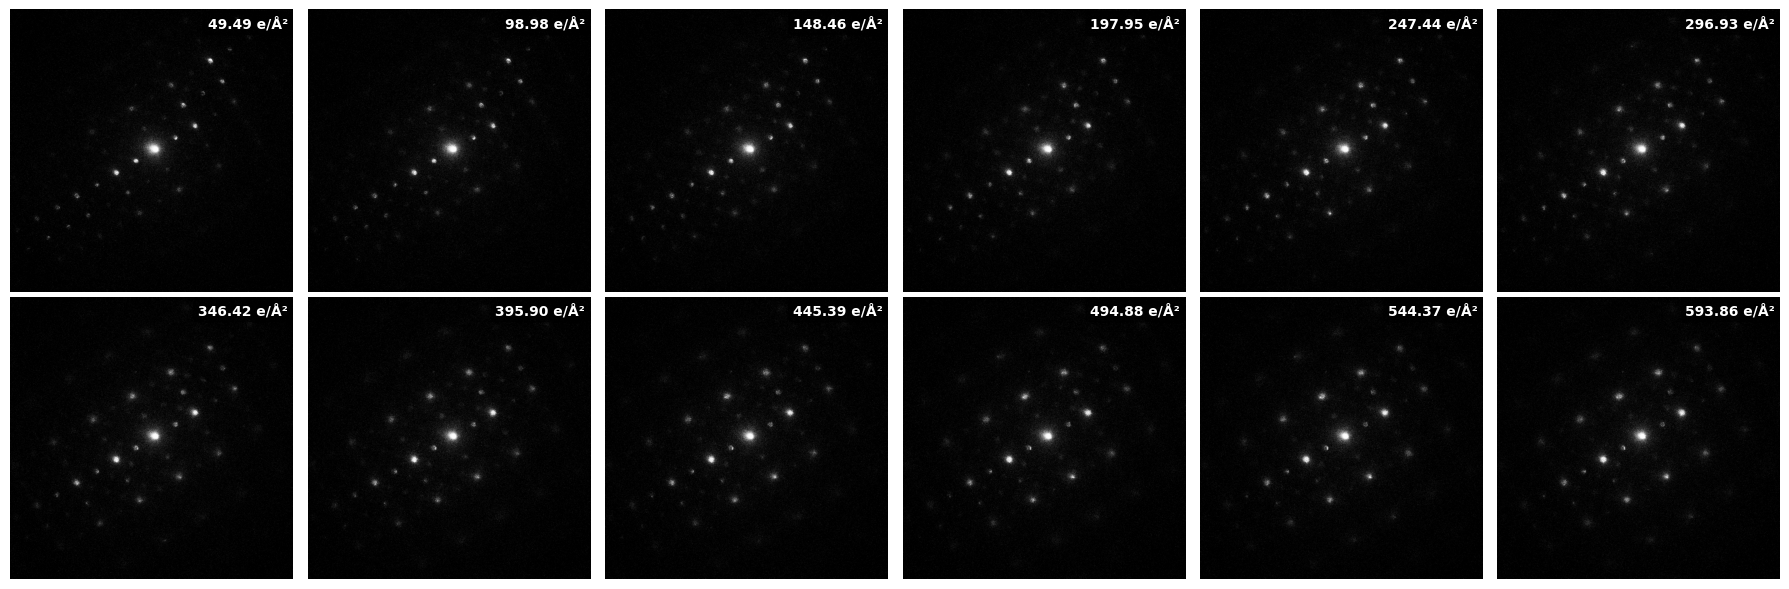

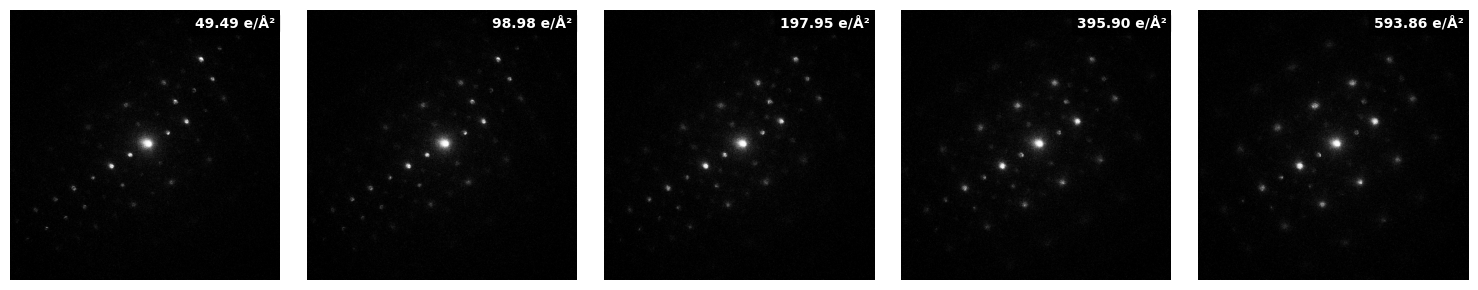

In [ ]:
import os

# --- 디렉토리 확인 및 생성 ---
save_dir = "DP_diffraction_series"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# --- 첫 번째 subplot (2행 6열) ---
fig, axes = plt.subplots(2, 6, figsize=(18, 6))
axes = axes.flatten()

for i in range(12):
    ax = axes[i]
    img = summed_images[i]
    dose_text = f"{dose_values[i]:.2f} e/Å²"

    ax.imshow(img, cmap='gray')
    ax.axis("off")

    height, width = img.shape[:2]
    x_pos = width - 60
    y_pos = 80

    ax.text(x_pos, y_pos, dose_text,
            color='white', fontsize=10, weight='bold',
            ha='right', va='top',
            bbox=dict(facecolor='black', alpha=0.4, boxstyle='round,pad=0.3'))

for j in range(len(summed_images), len(axes)):
    axes[j].axis("off")

plt.tight_layout()
full_filename = os.path.join(save_dir, f"full_series_{nb_name.replace('.ipynb', '')}.png")
plt.savefig(full_filename, dpi=300, bbox_inches='tight')
plt.show()

# --- 두 번째 subplot (1행 5열) ---
selected_indices = [0, 1, 3, 7, 11]
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
axes = axes.flatten()

for ax, idx in zip(axes, selected_indices):
    img = summed_images[idx]
    dose_text = f"{dose_values[idx]:.2f} e/Å²"

    ax.imshow(img, cmap='gray')
    ax.axis("off")

    height, width = img.shape[:2]
    x_pos = width - 60
    y_pos = 80

    ax.text(x_pos, y_pos, dose_text,
            color='white', fontsize=10, weight='bold',
            ha='right', va='top',
            bbox=dict(facecolor='black', alpha=0.4, boxstyle='round,pad=0.3'))

plt.tight_layout()
selected_filename = os.path.join(save_dir, f"selected_series_{nb_name.replace('.ipynb', '')}.png")
plt.savefig(selected_filename, dpi=300, bbox_inches='tight')
plt.show()


In [93]:
import json
import os
import re
import ipykernel
import requests



print(f"현재 Jupyter Notebook 파일 이름: {nb_name}")

import pickle

# 파일 이름에서 확장자 (.ipynb) 제거 후 .pkl 파일명으로 설정
pkl_filename = nb_name.replace(".ipynb", ".pkl")

data_to_save = {
    "cumulative_dose": cumulative_dose,
    "normalized_diff": normalize(difference_list_adjusted),
    "highlight_intensities": [0.75, 0.5],
    "difference_list_adjusted": difference_list_adjusted,
    "PbI2_list_adjusted": PbI2_list_adjusted,
    "Perov_list_adjusted": Perov_list_adjusted,
    "Center_list_adjusted": Center_list_adjusted,
    "background_list_adjusted": background_list_adjusted
}

# 저장하기
with open(pkl_filename, "wb") as f:
    pickle.dump(data_to_save, f)

print(f"데이터 저장 완료: {pkl_filename}")

현재 Jupyter Notebook 파일 이름: ROI2-RT-A2
데이터 저장 완료: ROI2-RT-A2


In [94]:
import os
import nbformat
import pickle
import hyperspy.api as hs
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import cmasher as cmr
import os
import numba
import cv2
from IPython.display import Video
from scipy.optimize import curve_fit
from matplotlib.patches import Rectangle, Circle
from matplotlib.patches import Polygon
from matplotlib.path import Path
from matplotlib.lines import Line2D


def get_notebook_name():
    """현재 실행 중인 Jupyter Notebook의 파일명을 가져옴"""
    for file in os.listdir():
        if file.endswith(".ipynb"):
            with open(file, "r", encoding="utf-8") as f:
                try:
                    nb_data = nbformat.read(f, as_version=4)
                    if "metadata" in nb_data and "kernelspec" in nb_data["metadata"]:
                        return file
                except Exception:
                    continue
    return "default_notebook.ipynb"  # 찾을 수 없을 때 기본값


print(f"현재 Jupyter Notebook 파일 이름: {nb_name}")

# 저장된 파일 불러오기
with open(nb_name.replace(".ipynb", ".pkl"), "rb") as f:
    loaded_data = pickle.load(f)

cumulative_dose = loaded_data["cumulative_dose"]
normalized_diff = loaded_data["normalized_diff"]
highlight_intensities = loaded_data["highlight_intensities"]
difference_list_adjusted = loaded_data["difference_list_adjusted"]
PbI2_list_adjusted = loaded_data["PbI2_list_adjusted"]
Perov_list_adjusted = loaded_data["Perov_list_adjusted"]
Center_list_adjusted = loaded_data["Center_list_adjusted"]
background_list_adjusted = loaded_data["background_list_adjusted"]

print("데이터 로드 완료 ✅")

# Function to normalize data
def normalize(data):
    first_val = data[0]  # 첫 번째 값
    return [val / first_val for val in data]

# Function to find the closest index for a given value
def find_closest_index(array, value):
    return np.argmin(np.abs(array - value))

def find_closest_dose(dose_list, intensity_list, target_intensity):
    """
    target_intensity와 가장 가까운 값을 찾고, 해당하는 dose 값을 반환.
    """
    idx = np.abs(np.array(intensity_list) - target_intensity).argmin()
    return dose_list[idx], intensity_list[idx]  # (dose, intensity)

data_lists = [
    (difference_list_adjusted, "Difference List"),
    (PbI2_list_adjusted, "PbI2 Intensity"),
    (Perov_list_adjusted, "Perovskite Intensity"),
    (Center_list_adjusted, "Center Intensity"),
    (background_list_adjusted, "Background Intensity"),
]


현재 Jupyter Notebook 파일 이름: ROI2-RT-A2
데이터 로드 완료 ✅


In [95]:
import numpy as np

# 데이터 (예제)
data = np.column_stack((cumulative_dose, normalized_diff))

# # 엑셀 복붙용 출력 (탭으로 구분)
# np.savetxt("output.txt", data, fmt="%.6f", delimiter="\t")  # 소수점 6자리까지 출력

# 파일 없이 바로 콘솔에 출력
for row in data:
    print(f"{row[0]:.6f}\t{row[1]:.6f}")


0.000000	1.000000
3.093000	1.008149
6.186000	0.968155
9.279000	1.017737
12.372000	0.992344
15.465000	1.031411
18.558000	1.020605
21.651000	1.013399
24.744000	1.024073
27.837000	0.950745
30.930000	0.877264
34.023000	0.937387
37.116000	0.978041
40.209000	0.909700
43.302000	1.037786
46.395000	0.954363
49.488000	0.986017
52.581000	0.940307
55.674000	0.863896
58.767000	1.050379
61.860000	0.911744
64.953000	1.002918
68.046000	0.858817
71.139000	0.936765
74.232000	0.901635
77.325000	0.963125
80.418000	0.911557
83.511000	0.962377
86.604000	0.868137
89.697000	0.919194
92.790000	0.911261
95.883000	0.889967
98.976000	0.911129
102.069000	0.851940
105.162000	0.892840
108.255000	0.861445
111.348000	0.888714
114.441000	0.876463
117.534000	0.919090
120.627000	0.904371
123.720000	0.865614
126.813000	0.908215
129.906000	0.915475
132.999000	0.923449
136.092000	0.928367
139.185000	0.917749
142.278000	0.885897
145.371000	0.835971
148.464000	0.912663
151.557000	0.827928
154.650000	0.856870
157.743000	0.9601

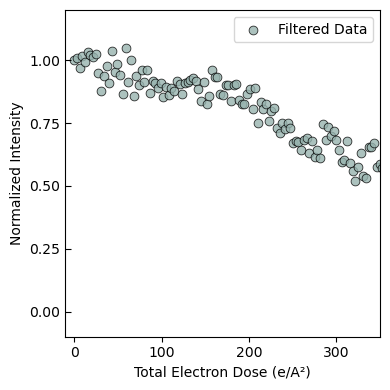

In [96]:
import numpy as np
import matplotlib.pyplot as plt

# NumPy 배열 변환 (모든 데이터)
cumulative_dose = np.array(cumulative_dose)
normalized_diff = np.array(normalized_diff)
PbI2_list_adjusted = np.array(PbI2_list_adjusted)
Perov_list_adjusted = np.array(Perov_list_adjusted)
Center_list_adjusted = np.array(Center_list_adjusted)
background_list_adjusted = np.array(background_list_adjusted)

# 데이터 리스트 (필터링할 모든 데이터)
data_lists = [
    (normalized_diff, "Difference List"),
    (PbI2_list_adjusted, "PbI2 Intensity"),
    (Perov_list_adjusted, "Perovskite Intensity"),
    (Center_list_adjusted, "Center Intensity"),
    (background_list_adjusted, "Background Intensity"),
]

def remove_outliers(x_data, y_data, remove_ranges):
    """
    특정 x 구간의 데이터를 삭제하는 함수.
    
    Parameters:
        x_data (np.array): x축 데이터 (총 전자선량)
        y_data (np.array): y축 데이터 (정규화된 강도)
        remove_ranges (list of tuples): 삭제할 x 구간 리스트 (예: [(200, 220), (300, 320)] )
    
    Returns:
        np.array, np.array: outlier 제거 후의 x_data, y_data
    """
    x_data = np.array(x_data)
    y_data = np.array(y_data)

    mask = np.ones(len(x_data), dtype=bool)  # 전체 데이터를 True로 초기화
    for r in remove_ranges:
        mask &= ~((x_data >= r[0]) & (x_data <= r[1]))  # 해당 구간을 False로 설정
    return x_data[mask], y_data[mask]

# 삭제할 구간 리스트 (두 개의 구간을 삭제)
remove_ranges = [(9999,9999), (9999, 9999)]  

# 모든 데이터 필터링
filtered_cumulative_dose, _ = remove_outliers(cumulative_dose, normalized_diff, remove_ranges)

filtered_results = []
for data, label in data_lists:
    filtered_x, filtered_y = remove_outliers(cumulative_dose, data, remove_ranges)
    filtered_results.append((filtered_x, filtered_y, label))

# 새로운 데이터 플롯
fig, ax = plt.subplots(figsize=(4, 4))

# Difference List 데이터 플롯
ax.scatter(filtered_results[0][0], filtered_results[0][1], label="Filtered Data",
           facecolors="#97B3AE", edgecolors="black", linewidths=0.6,
           alpha=0.8, s=40, marker="o")

ax.set_xlabel("Total Electron Dose (e/A²)")
ax.set_ylabel("Normalized Intensity")
ax.set_ylim(-0.1, 1.2)
ax.set_xlim(-10, 350)
ax.set_yticks(np.arange(0, 1.25, 0.25))  
ax.tick_params(axis='y', direction='in', length=4)  

ax.legend()
plt.tight_layout()
plt.show()


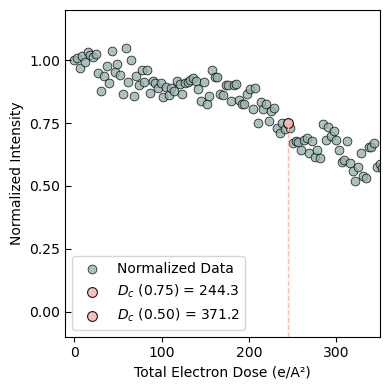

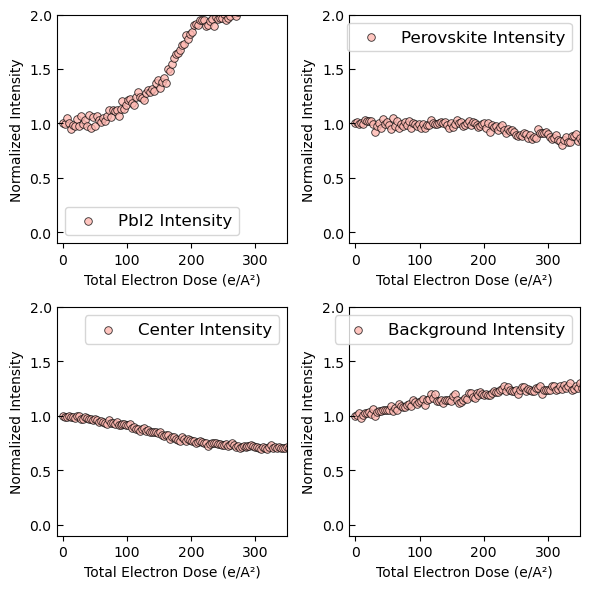

✅ 저장 완료: Graphs_component\components_ROI2-RT-A2.png


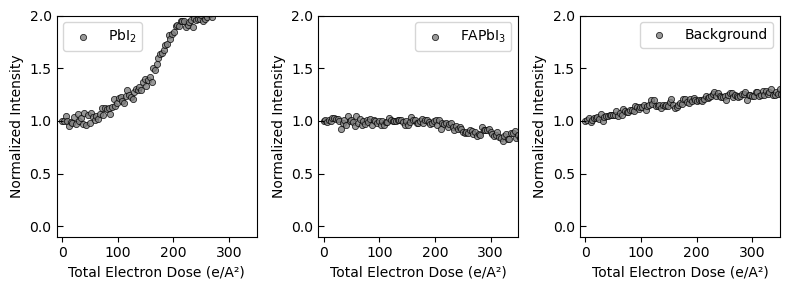

In [97]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# 📌 Plotting for Difference List (large plot)
fig_diff, ax_diff = plt.subplots(figsize=(4, 4))

# Difference List 데이터 참조 (filtered_results 리스트에서 직접 사용)
ax_diff.scatter(filtered_results[0][0], filtered_results[0][1], label="Normalized Data",
                facecolors="#97B3AE", edgecolors="black", linewidths=0.6,
                alpha=0.8, s=40, marker="o")

ax_diff.set_xlabel("Total Electron Dose (e/A²)")
ax_diff.set_ylabel("Normalized Intensity")
ax_diff.set_ylim(-0.1, 1.2)
ax_diff.set_xlim(-10, 350)
ax_diff.set_yticks(np.arange(0, 1.25, 0.25))  # Set y-axis tick interval to 0.25
ax_diff.tick_params(axis='y', direction='in', length=4)  # Set ticks to be inside

# 📌 Highlight specific intensity points (0.75 and 0.5)
for intensity in [0.75, 0.5]:
    dose, value = find_closest_dose(filtered_results[0][0], filtered_results[0][1], intensity)
    ax_diff.scatter(dose, value, color="#FFB8B1", edgecolors="black",
                    linewidths=0.8, alpha=0.9, s=50, marker="o",
                    label=f"$D_{{c}}$ ({value:.2f}) = {dose:.1f}")

    # Add dashed guide lines
    line_x = Line2D([dose, dose], [-0.1, value], color="#FFB8B1", linestyle="--", linewidth=1)
    ax_diff.add_line(line_x)

ax_diff.legend()
plt.tight_layout()
plt.show()

# 📌 Plotting for other datasets (2x2 grid)
fig_others, axes_others = plt.subplots(2, 2, figsize=(6, 6))
axes_others = axes_others.ravel()

for i, (filtered_x, filtered_y, title) in enumerate(filtered_results[1:]):  # Difference List 제외
    normalized_data = normalize(filtered_y)  # Normalize the data
    axes_others[i].scatter(filtered_x, normalized_data, label=title,
                           facecolors="#FFB8B1", edgecolors="black", linewidths=0.6,
                           alpha=0.8, s=30, marker="o")

    axes_others[i].set_xlabel("Total Electron Dose (e/A²)")
    axes_others[i].set_ylabel("Normalized Intensity")
    axes_others[i].set_ylim(-0.1, 2.0)
    axes_others[i].set_xlim(-10, 350)
    axes_others[i].legend(fontsize=12)
    axes_others[i].tick_params(axis='y', direction='in', length=4)  # Set ticks to be inside

# Hide the empty subplot if any
if len(filtered_results[1:]) < len(axes_others):
    axes_others[-1].axis("off")

plt.tight_layout()
plt.show()


# 📌 Plotting PbI2, FAPbI3, Background Intensity Only (1x3)
fig_selected, axes_selected = plt.subplots(1, 3, figsize=(8, 3))

# 변경된 label 명
legend_labels = ["PbI$_2$", "FAPbI$_3$", "Background"]
selected_indices = [1, 2, 4]  # filtered_results의 해당 index

for ax, idx, label in zip(axes_selected, selected_indices, legend_labels):
    filtered_x, filtered_y, _ = filtered_results[idx]
    normalized_y = normalize(filtered_y)

    ax.scatter(filtered_x, normalized_y, label=label,
               facecolors="gray", edgecolors="black", linewidths=0.6,
               alpha=0.8, s=20, marker="o")

    ax.set_xlabel("Total Electron Dose (e/A²)")
    ax.set_ylabel("Normalized Intensity")
    ax.set_ylim(-0.1, 2.0)
    ax.set_xlim(-10, 350)
    ax.tick_params(axis='y', direction='in', length=4)
    ax.legend(fontsize=10)

plt.tight_layout()

# --- 디렉토리 생성 및 저장 ---
save_dir = "Graphs_component"
os.makedirs(save_dir, exist_ok=True)

save_path = os.path.join(save_dir, f"components_{nb_name.replace('.ipynb', '')}.png")
plt.savefig(save_path, dpi=300)
print(f"✅ 저장 완료: {save_path}")

plt.show()


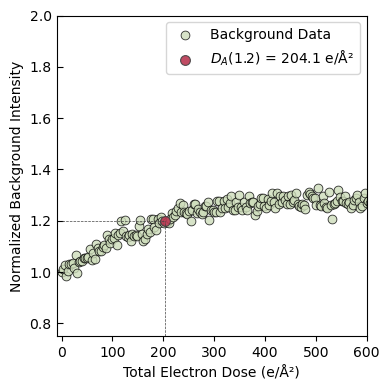

In [98]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import os
import csv

# --- 데이터 준비 ---
background_intensity = np.array(data_lists[4][0])
total_electron_dose = np.array(cumulative_dose)
normalized_background = np.array(normalize(background_intensity))

# --- y=1.2에 가장 가까운 값 찾기 ---
target_y = 1.2
differences = np.abs(normalized_background - target_y)
min_index = np.argmin(differences)
Da_val = total_electron_dose[min_index]
highlight_y = normalized_background[min_index]

# --- 시각화 ---
fig_background, ax_background = plt.subplots(figsize=(4, 4))
ax_background.scatter(total_electron_dose, normalized_background, label="Background Data",
                      facecolors="#CEDDBB", edgecolors="black", linewidths=0.6,
                      alpha=0.8, s=40, marker="o")

# 하이라이트된 D_A 지점 표시
ax_background.scatter(Da_val, highlight_y, color="#B93752", edgecolors="#434343",
                      linewidths=0.8, alpha=0.9, s=50, marker="o",
                      label=f"$D_A$(1.2) = {Da_val:.1f} e/Å²")

# 점선 안내선
ax_background.add_line(Line2D([Da_val, Da_val], [0.75, highlight_y], color="#434343", linestyle="--", linewidth=0.5))
ax_background.add_line(Line2D([0, Da_val], [highlight_y, highlight_y], color="#434343", linestyle="--", linewidth=0.5))

# Plot 설정
ax_background.set_xlabel("Total Electron Dose (e/Å²)")
ax_background.set_ylabel("Normalized Background Intensity")
ax_background.set_ylim(0.75, 2.0)
ax_background.set_xlim(-10, 600)
ax_background.legend()
ax_background.tick_params(axis='y', direction='in', length=4)
plt.tight_layout()

# --- 이미지 저장 ---
save_dir = "Graphs_background_collections"
os.makedirs(save_dir, exist_ok=True)
nb_base = os.path.splitext(nb_name)[0]
image_path = os.path.join(save_dir, f"{nb_base}_background_nearest_to_1.2.png")
plt.savefig(image_path, dpi=300)
plt.show()

# --- D_A 값 저장 ---
csv_path = "background_DA.csv"
header = ["index", "D_A"]

file_exists = os.path.isfile(csv_path)
with open(csv_path, mode='a', newline='') as file:
    writer = csv.writer(file)
    if not file_exists:
        writer.writerow(header)
    writer.writerow([nb_base, f"{Da_val:.1f}"])


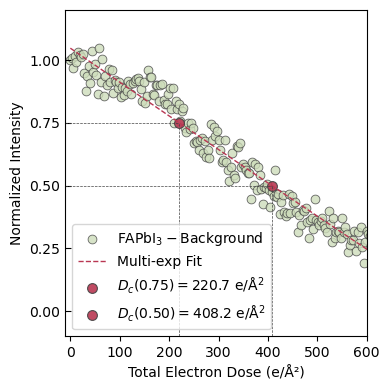

In [99]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.optimize import curve_fit
import os
import csv

# 📌 다중 지수 함수 정의
def multi_exp_fit(x, a1, b1, a2, b2, c):
    return a1 * np.exp(-b1 * x) + a2 * np.exp(-b2 * x) + c

# 📌 Difference List 데이터 준비
filtered_cumulative_dose, filtered_normalized_diff, _ = filtered_results[0]

# 📌 NaN/Inf 제거
valid_indices = ~(np.isnan(filtered_cumulative_dose) | np.isnan(filtered_normalized_diff) | 
                  np.isinf(filtered_cumulative_dose) | np.isinf(filtered_normalized_diff))
filtered_cumulative_dose = filtered_cumulative_dose[valid_indices]
filtered_normalized_diff = filtered_normalized_diff[valid_indices]

# 📌 커브 피팅
try:
    popt, _ = curve_fit(multi_exp_fit, filtered_cumulative_dose, filtered_normalized_diff, 
                        p0=[2, 0.005, 1, 0.0005, 0], maxfev=1000000)
except RuntimeError as e:
    print(f"Curve fitting failed: {e}")
    popt = [np.nan] * 5

# 📌 피팅 곡선
x_fit = np.linspace(min(filtered_cumulative_dose), max(filtered_cumulative_dose), 500)
y_fit = multi_exp_fit(x_fit, *popt) if not np.isnan(popt[0]) else np.full_like(x_fit, np.nan)

# 📌 Dc 계산
Dc_values = {}
if not np.isnan(popt[0]):
    for intensity in [0.75, 0.5]:
        dose = np.interp(intensity, y_fit[::-1], x_fit[::-1])
        Dc_values[intensity] = dose

# 📌 플롯
fig_diff, ax_diff = plt.subplots(figsize=(4, 4))
ax_diff.scatter(filtered_cumulative_dose, filtered_normalized_diff, 
                label=r"$\mathrm{FAPbI}_3 - \mathrm{Background}$",
                facecolors="#CEDDBB", edgecolors="#434343", linewidths=0.6,
                alpha=0.8, s=40, marker="o")

if not np.isnan(popt[0]):
    ax_diff.plot(x_fit, y_fit, color="#B93752", linestyle="--", linewidth=1.0, label="Multi-exp Fit")

# 축 설정
ax_diff.set_xlabel("Total Electron Dose (e/Å²)")
ax_diff.set_ylabel("Normalized Intensity")
ax_diff.set_ylim(-0.1, 1.2)
ax_diff.set_xlim(-10, 600)
ax_diff.set_yticks(np.arange(0, 1.25, 0.25))
ax_diff.tick_params(axis='y', direction='in', length=4)

# 하이라이트 및 점선
if Dc_values:
    for intensity, dose in Dc_values.items():
        value = multi_exp_fit(dose, *popt)
        ax_diff.scatter(dose, value, color="#B93752", edgecolors="#434343",
                        linewidths=0.8, alpha=0.9, s=50, marker="o",
                        label = fr"$D_{{c}}({intensity:.2f}) = {dose:.1f}\ \mathrm{{e}}/\mathrm{{\AA}}^2$")
        ax_diff.add_line(Line2D([dose, dose], [-0.1, value], color="#434343", linestyle="--", linewidth=0.5))
        ax_diff.add_line(Line2D([-10, dose], [value, value], color="#434343", linestyle="--", linewidth=0.5))

ax_diff.legend()
plt.tight_layout()
plt.show()

# 📌 이미지 저장
save_dir = "Graphs_difference_collection"
os.makedirs(save_dir, exist_ok=True)
nb_base = os.path.splitext(nb_name)[0]  # 예: ROI1-200K-A17
image_path = os.path.join(save_dir, f"{nb_base}_difference_fit.png")
fig_diff.savefig(image_path, dpi=300)

# 📌 CSV 저장
csv_path = "difference_DC.csv"
header = ["index", "D_C(0.75)", "D_C(0.50)"]
file_exists = os.path.isfile(csv_path)

with open(csv_path, mode='a', newline='') as f:
    writer = csv.writer(f)
    if not file_exists:
        writer.writerow(header)
    dc_075 = f"{Dc_values.get(0.75, 'NaN'):.1f}" if 0.75 in Dc_values else "NaN"
    dc_050 = f"{Dc_values.get(0.5, 'NaN'):.1f}" if 0.5 in Dc_values else "NaN"
    writer.writerow([nb_base, dc_075, dc_050])

# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.lines import Line2D
# import os
# import csv

# # 📌 Difference List 데이터 준비
# filtered_cumulative_dose, filtered_normalized_diff, _ = filtered_results[0]

# # 📌 NaN/Inf 제거
# valid_indices = ~(np.isnan(filtered_cumulative_dose) | np.isnan(filtered_normalized_diff) | 
#                   np.isinf(filtered_cumulative_dose) | np.isinf(filtered_normalized_diff))
# filtered_cumulative_dose = filtered_cumulative_dose[valid_indices]
# filtered_normalized_diff = filtered_normalized_diff[valid_indices]

# # 📌 Dc 계산 (피팅 없이 직접 검색)
# Dc_values = {}
# for target_y in [0.75, 0.5]:
#     differences = np.abs(filtered_normalized_diff - target_y)
#     min_index = np.argmin(differences)
#     Dc_values[target_y] = filtered_cumulative_dose[min_index]

# # 📌 플롯
# fig_diff, ax_diff = plt.subplots(figsize=(4, 4))
# ax_diff.scatter(filtered_cumulative_dose, filtered_normalized_diff, 
#                 label=r"$\mathrm{FAPbI}_3 - \mathrm{Background}$",
#                 facecolors="#CEDDBB", edgecolors="#434343", linewidths=0.6,
#                 alpha=0.8, s=40, marker="o")

# # 하이라이트 및 점선
# for intensity, dose in Dc_values.items():
#     value = filtered_normalized_diff[np.argmin(np.abs(filtered_normalized_diff - intensity))]
#     ax_diff.scatter(dose, value, color="#B93752", edgecolors="#434343",
#                     linewidths=0.8, alpha=0.9, s=50, marker="o",
#                     label = fr"$D_{{c}}({intensity:.2f}) = {dose:.1f}\ \mathrm{{e}}/\mathrm{{\AA}}^2$")
#     ax_diff.add_line(Line2D([dose, dose], [-0.1, value], color="#434343", linestyle="--", linewidth=0.5))
#     ax_diff.add_line(Line2D([-10, dose], [value, value], color="#434343", linestyle="--", linewidth=0.5))

# # 축 설정
# ax_diff.set_xlabel("Total Electron Dose (e/Å²)")
# ax_diff.set_ylabel("Normalized Intensity")
# ax_diff.set_ylim(-0.1, 1.2)
# ax_diff.set_xlim(-10, 600)
# ax_diff.set_yticks(np.arange(0, 1.25, 0.25))
# ax_diff.tick_params(axis='y', direction='in', length=4)
# ax_diff.legend()
# plt.tight_layout()
# plt.show()

# # 📌 이미지 저장
# save_dir = "Graphs_difference_collection"
# os.makedirs(save_dir, exist_ok=True)
# nb_base = os.path.splitext(nb_name)[0]  # 예: ROI1-200K-A17
# image_path = os.path.join(save_dir, f"{nb_base}_difference_closest.png")
# fig_diff.savefig(image_path, dpi=300)

# # 📌 CSV 저장
# csv_path = "difference_DC.csv"
# header = ["index", "D_C(0.75)", "D_C(0.50)"]
# file_exists = os.path.isfile(csv_path)

# with open(csv_path, mode='a', newline='') as f:
#     writer = csv.writer(f)
#     if not file_exists:
#         writer.writerow(header)
#     dc_075 = f"{Dc_values.get(0.75, 'NaN'):.1f}" if 0.75 in Dc_values else "NaN"
#     dc_050 = f"{Dc_values.get(0.5, 'NaN'):.1f}" if 0.5 in Dc_values else "NaN"
#     writer.writerow([nb_base, dc_075, dc_050])
